In [2]:
#| echo: false

import geopandas as gpd
import pandas as pd
import janitor
import matplotlib.pyplot as plt
import json
import pandas as pd
import requests
import os
from datetime import date #, timedelta
import janitor
from datetime import date, datetime,timedelta
import sys
import zipfile


/Users/polcarbo/anaconda3/envs/grasscast_env/lib/python3.10/site-packages/janitor/utils.py:84: FutureWarning: PandasArray has been renamed NumpyExtensionArray. Use that instead. This alias will be removed in a future version.
  @_expand_grid.register(pd.arrays.PandasArray)


#
#
# FoodSight

This project focuses on providing non-experts in data analysis with easy access to farming and ranching data. It offers a user-friendly tool to engage with dynamic and interactive outputs from the GrassCast Aboveground Net Primary Productivity (ANPP) model, a collaborative effort between the University of Nebraska–Lincoln, USDA, NDMC, Colorado State University, and the University of Arizona. Although static maps and CSV files from this model are available at [https://grasscast.unl.edu/](https://grasscast.unl.edu/), their complexity can be challenging for general audiences. Our web application simplifies access, visualization, and interpretation of this data, and includes basic spatial analysis tools for insights into expected productivity for each growing season.

Moreover, the application integrates GrassCast scenarios with Climate Outlooks from the Climate Prediction Center of the National Weather Service, available at [https://www.cpc.ncep.noaa.gov/products/predictions/long_range/interactive/index.php](https://www.cpc.ncep.noaa.gov/products/predictions/long_range/interactive/index.php). This feature enhances the understanding of likely scenarios.

Additionally, the application has sections dedicated to ranching and farming market data, sourced from the My Market News USDA API. This allows users to directly access and analyze market data and trends for Cattle and Hay commodities, across all US auctions. Furthermore, the application includes a decision-making tool developed by Colorado State University, particularly useful during drought conditions.

## Overview

For constructing the applications, we utilized AWS services including ElasticBeanstalk, Lambda, S3, and EC2 instances. The backend code is designed to automate data retrieval through API integrations and web scraping. These services are employed to store, update, and process data for display in an interactive application, which is hosted at [https://app.foodsight.org/](https://app.foodsight.org/). The diagram below presents an overview of the architectural structure designed around the application, ensuring the provision of updated and interactive information.

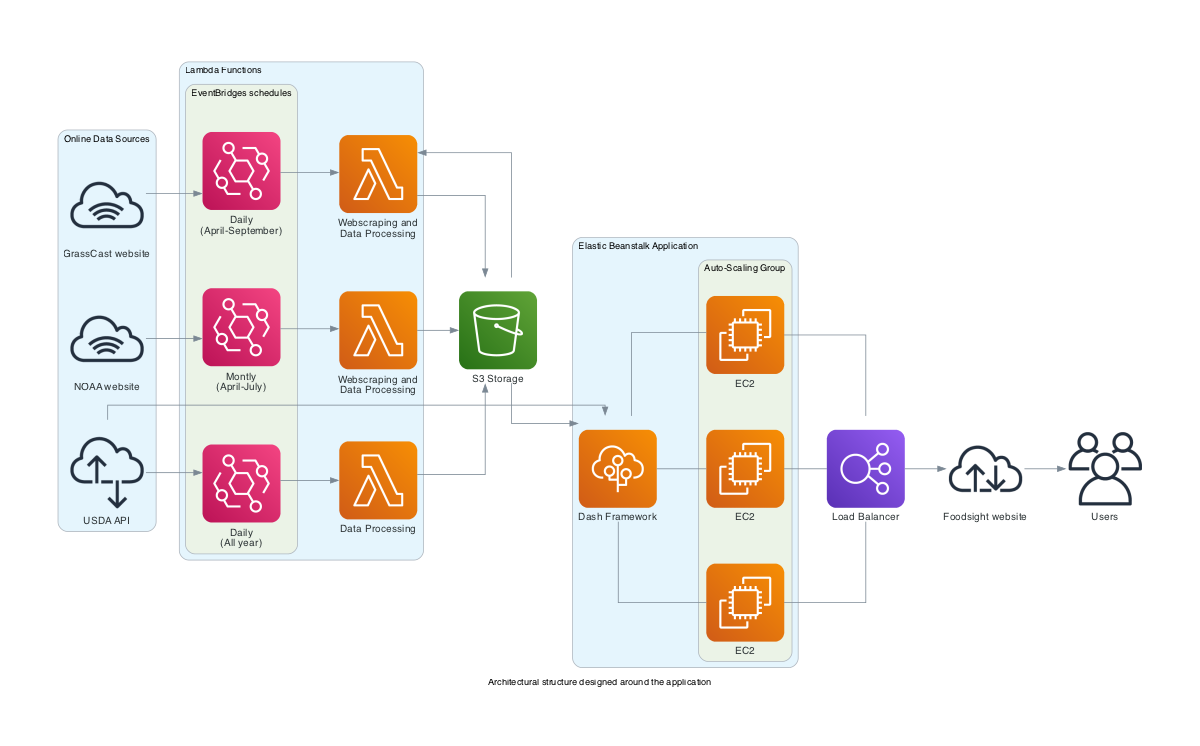

In [2]:
#| echo: false

from diagrams import Diagram, Cluster
from diagrams.aws.compute import Lambda, EC2, ElasticBeanstalk
from diagrams.aws.storage import S3
from diagrams.aws.network import ELB
from diagrams.aws.integration import Eventbridge
from diagrams.aws.general import InternetGateway, InternetAlt1, InternetAlt2, Users

graph_attrs = {
    "pad": "1",
    "nodesep": "0.50",
    "ranksep": "0.75",
    "fontname": "Sans-Serif",
    "fontsize": "12",
    "fontcolor": "#000000",
    "size": "6,6", 
    "dpi": "200"
}

with Diagram("Architectural structure designed around the application", show=False, direction="LR", graph_attr=graph_attrs) as diag:
    with Cluster("Online Data Sources"):
        ws1 = InternetGateway("GrassCast website")
        ws2 = InternetGateway("NOAA website")
        ws3 = InternetAlt1("USDA API")

    with Cluster("Lambda Functions"):
        lambda1 = Lambda("Webscraping and\nData Processing")        
        lambda2 = Lambda("Webscraping and\nData Processing")
        lambda3 = Lambda("Data Processing")
        
        with Cluster("EventBridges schedules"):
            eb1 = Eventbridge("Daily\n(April-September)")
            eb2 = Eventbridge("Montly\n(April-July)")
            eb3 = Eventbridge("Daily\n(All year)")

    with Cluster("Elastic Beanstalk Application"):
        eb_env = ElasticBeanstalk("Dash Framework")
        with Cluster("Auto-Scaling Group"):
            ec2_instances = [EC2("EC2"), EC2("EC2"), EC2("EC2")]

        eb_env - ec2_instances

    lb = ELB("Load Balancer")
    s3 = S3("S3 Storage")
    web = InternetAlt2("Foodsight website")
    users = Users("Users")

    ws1 >> eb1 >> lambda1 >> s3 >> lambda1
    ws2 >> eb2 >> lambda2 >> s3
    ws3 >> eb3 >> lambda3 >> s3
    ws3 >> eb_env
    s3 >> eb_env 
    ec2_instances - lb
    lb >> web >> users

diag


The following sections will explain in more detail the data used, as well as the acquisition and processing techniques implemented.

## Web application

Developed using Python's Dash framework, FoodSight offers an interactive and user-friendly interface, allowing users to explore grasslands productivity forecast and cattle market data.

Python Dash, known for its simplicity and efficiency, forms the backbone of FoodSight's back and front end code. Dash framework enables the seamless integration of Python's robust data processing capabilities with modern web technologies, creating a dynamic and responsive user experience. Dash's ability to handle complex data visualizations and real-time updates makes it the ideal choice for FoodSight.

The deployment of the app on AWS Elastic Beanstalk further enhances its accessibility and scalability. Elastic Beanstalk, a service provided by Amazon Web Services (AWS), offers an easy-to-use platform for deploying and managing web applications. By leveraging Elastic Beanstalk, FoodSight benefits of automatic scaling, load balancing, and health monitoring, ensuring that the application remains robust and responsive.

The application's code and dependencies associated with Elastic Beanstalk deployment can be found in the "foodsight-app" folder within this repository. Though the core element of the application is the interactive display of ANPP forecast data, the application also contains two additional main pages, one for market data and another for a decision-making tool.

### Forecast page

This section presents the Grassland Productivity Forecast generated by Grasscast from the National Drought Mitigation Center at the University of Nebraska-Lincoln. The forecast is summarized based on county or map selection. Expected production is correlated with anticipated climate scenarios from the NOAA Climate Prediction Center. Users can access the most recent forecast value released and track forecast trends until the end of each season. Additionally, one can navigate through historical data to view past productivity. The platform also enables users to spatially identify areas with higher productivity in comparison to a current location or a selected location on the map. This feature is particularly useful for exploring productivity across the southwest plains. Ranchers and land managers should use this information in combination with their local knowledge of soils, plant communities, topography, and management to help with decision-making.

![](img/forecast_page.png)

### Markets page


This section provides access to nominal data from several cattle and hay market auctions. The data is sourced from the MyMarketNews API, a USDA service that offers unbiased, timely, and accurate market information for hundreds of agricultural commodities and their related products. This interface features multiple tabs, enabling users to select a specific time range, cattle or hay type, state, and auction market. For cattle, users can choose between viewing daily average prices or monthly aggregated prices. Furthermore, users can visualize the relationship between prices and weight based on the most recent auction data. For hay, the platform showcases daily average price trends across various markets.

![](img/markets_page.png)


### Decision Support Tool page

This section integrates the 'Strategies for Beef Cattle Herds During Times of Drought,' designed by Jeffrey E. Tranel, Rod Sharp, & John Deering from the Department of Agriculture and Business Management at Colorado State University. This decision tool aims to assist cow-calf producers in comparing the financial implications of various management strategies during droughts when grazing forage becomes scarce. It serves as a guide only. Producers should consult with their lenders, tax practitioners, and/or other professionals before making any final decisions.

![](img/tool_page.png)


### Third party dependencies

The application framework requires services provided by third parties, for which a user account is needed. Specifically, the application makes calls to access these services using personal tokens that are not included in this repository. As seen in the app code and throughout this document, such accounts are:

- Mapbox: The forecast sections of the map require a Mapbox token, which can be obtained by creating a free account at [https://www.mapbox.com/](https://www.mapbox.com/). Store this token in the .mapbox_token variable within the app.

- MyMarketNews API: All market data is provided by a USDA API, which also requires a user account and authentication using a token. Store this token in the .mmn_api_token variable within the code. You can create a free account at [https://mymarketnews.ams.usda.gov/mymarketnews-api/](https://mymarketnews.ams.usda.gov/mymarketnews-api/).

- AWS: The entire architectural structure of the app is deployed using Amazon Web Services (AWS), which also requires an account and authentication. Running this code on AWS may incur costs, so please be aware of this if you decide to implement it on your own.

## Data

There are three main sources of data used in the application. This includes the data related to grassland productivity derived from GrassCast and NOAA, as well as the market data extracted from USDA My Market News API. Next, we will go through these two groups of data and the processing conducted to feed the app.

### GrassCast and related data

The forecast data is available in two distinct forms: the most recent biweekly forecast values for each season and the time series with historical productivity values. For the former, the forecast outputs include three possible scenarios, which need to be correlated with the NOAA Climate Outlooks, another dataset considered in the data processing. Lastly, all GrassCast data has a spatial component, where forecast values are assigned to a grid of 10km x 10km cells. Each cell is assigned an ID corresponding to a polygon on a geofile and to an observation in the historical and forecast GrassCast datasets. Here, we will detail the data processing required to prepare the data to be read by the application.

#### Spatial data

Each GrassCast dataset is associated with a grid, with each row identified by an cell ID. The original grid for the entire USA was obtained from USDA in shapefile format. In the following lines, we will extract the cells of interest for the Great Plains (GP) and Southwest (SW) regions. Further, the application considers data summaries based on county location, which were processed based on GrassCast grid extension.

##### Grasscast Grid

###### Select grid cells of interest

The following code chunks include the workflow to select the grid cells of interest from the USDA grid shapefile. This is selecting the cells corresponding to the GP and SW, from the USDA grid containing all the USA continental territory (original_grid).

Due to a disparity in grid size between the historic and forecast datasets—the historic data contains some additional grid cell compared to the forecast dataset—we will proceed with the ids from the dataset that has a higher number of cells to extract the grid of interest from the "original_grid."

In [80]:
# Read original grid .shp from USDA
shapefile_path = '../testing_data/aws/spatial_data/raw/RAW-grid_10km_x_10km_fips/grid_10km_x_10km_fips.shp'
original_grid = gpd.read_file(shapefile_path)

###### South West cells

In [87]:
hist_grasscast_sw = pd.read_csv("../testing_data/aws/sw/hist_data_grasscast_sw.csv").clean_names()
# Getting unique cell_ids as a Series
cell_ids_series = pd.Series(hist_grasscast_sw['gridid'].unique(), name='gridid')
# Join csv data to the shapefile by 'Id' and 'gridid' fields respectively
joined_data = original_grid.merge(cell_ids_series.to_frame(), left_on='Id', right_on='gridid', how='inner')
joined_data.drop('gridid', axis=1, inplace=True)

Additionally, it is necessary to redefine the Coordinate Reference System (CRS) as both Folium and Plotly require the 'epsg:4326' CRS.

In [ ]:
joined_data = joined_data.rename(columns={'Id': 'gridid'})
joined_data = joined_data.to_crs(epsg=4326)

To avoid repeating the extraction process and enable easy access to the spatial data, we will save the grid of interest. 

In [ ]:
#| echo: false

joined_data.to_file("../testing_data/aws/spatial_data/sw_grid.geojson", driver='GeoJSON')

###### Great Plains cells

We will apply the same proceeding with the GP grid ids.

In [85]:
hist_grasscast_gp = pd.read_csv("../testing_data/aws/gp/hist_data_grasscast_gp.csv").clean_names()
# Getting unique cell_ids as a Series
cell_ids_series = pd.Series(hist_grasscast_gp['gridid'].unique(), name='gridid')
# Join csv data to the shapefile by 'Id' and 'gridid' fields respectively
joined_data2 = original_grid.merge(cell_ids_series.to_frame(), left_on='Id', right_on='gridid', how='inner')
joined_data2.drop('gridid', axis=1, inplace=True)
joined_data2 = joined_data2.rename(columns={'Id': 'gridid'})
joined_data2 = joined_data2.to_crs(epsg=4326)

In [ ]:
#| echo: false

joined_data2.to_file("../testing_data/aws/spatial_data/gp_grid.geojson", driver='GeoJSON')

Below you can see the extracted grids that we will use for data representation.

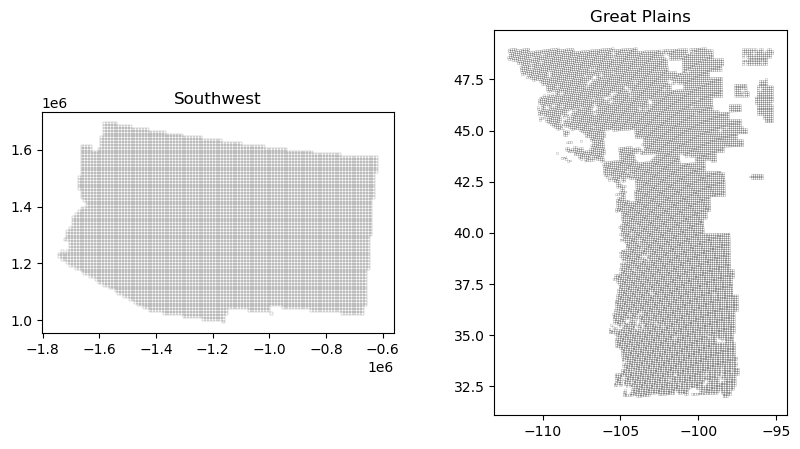

In [89]:
#| echo: false

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first shapefile on the first subplot
joined_data.plot(ax=ax1, facecolor='none', edgecolor='black', linewidth=0.1)
ax1.set_title('Southwest')  # Set a title for the first subplot

# Plot the second shapefile on the second subplot
joined_data2.plot(ax=ax2, facecolor='none', edgecolor='black', linewidth=0.1)
ax2.set_title('Great Plains')  # Set a title for the second subplot

# Display the plots
plt.show()

###### Overlaping cells

When evaluating, we can see that there are some overlapping cells between both regions.

In [91]:
#| echo: false

gp_grid = gpd.read_file("../testing_data/aws/spatial_data/gp_grid.geojson")
sw_grid = gpd.read_file("../testing_data/aws/spatial_data/sw_grid.geojson")

In [93]:
# Perform an inner join on the 'gridid' column
shared_gridids_df = pd.merge(gp_grid, sw_grid, on='gridid', how='inner')
# Extract unique 'gridid' values as a list
shared_gridids_list = shared_gridids_df['gridid'].unique().tolist()
# Save cell ids to a JSON file
shared_gridids_df = pd.DataFrame(shared_gridids_list, columns=['gridid'])

These overlapping IDs will be stored for future use in preparing the datasets and for use in the Lambda functions that will periodically update the data.

In [ ]:
#| echo: false

shared_gridids_df.to_json("../testing_data/aws/spatial_data/overlapping_gridids.json", orient='records')

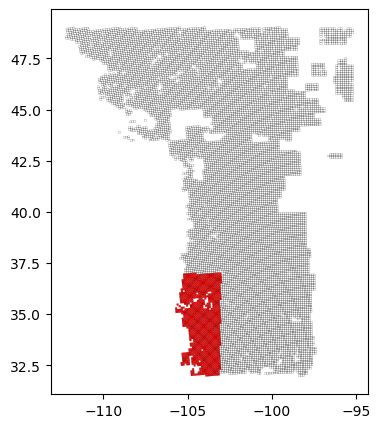

In [94]:
#| echo: false

# Create a boolean column in gp_grid that indicates if the gridid is in the shared list
gp_grid['is_shared'] = gp_grid['gridid'].isin(shared_gridids_list)
# Plotting setup
fig, ax = plt.subplots(figsize=(5, 5))
# Plot rows where 'is_shared' is False
gp_grid[gp_grid['is_shared'] == False].plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.1)
# Plot rows where 'is_shared' is True with a different color
gp_grid[gp_grid['is_shared'] == True].plot(ax=ax, facecolor='red', edgecolor='black', linewidth=0.1)
# Display the plot
plt.show()

To prevent any issues when combining both areas, we will remove overlapping cells from the GP grid. Additionally, we will display the forecast calculated for the SW since, as we will see in the following section, it provides information for two different seasons and does not have as many information gaps as the GP.

###### Combining both regions

Now, we will combine both regions to create the final GeoJSON file that will be loaded into the app.

In [95]:
gp_grid_exclusive = gp_grid[~gp_grid['gridid'].isin(shared_gridids_list)] # Exclude shared grid cells
combined_gdf = gpd.GeoDataFrame(pd.concat([gp_grid_exclusive, sw_grid], ignore_index=True)) # Combine the two GeoDataFrames

In [ ]:
#| echo: false

combined_gdf.to_file("../testing_data/aws/spatial_data/grasscast_aoi_grid.geojson", driver='GeoJSON')

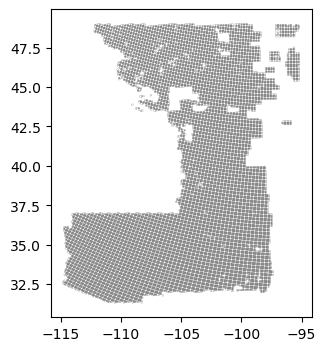

In [97]:
#| echo: false

# Plot the Shapefile to see the grid cells of interest
fig, ax = plt.subplots(figsize=(4, 4))
combined_gdf.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.1)
# Display the plot
plt.show()

###### List grid cells by AOI

Additionally, some of the backend code of the application will require knowing to which area (SW or GP) each cell is associated. Therefore, we will store a JSON file with the grid IDs grouped by the area of interest (AOI), whether it is SW or GP.

In [37]:
gp_grid = gpd.read_file("../testing_data/aws/spatial_data/gp_grid.geojson")
sw_grid = gpd.read_file("../testing_data/aws/spatial_data/sw_grid.geojson")
shared_gridids_df = pd.read_json("../testing_data/aws/spatial_data/overlapping_gridids.json")

In [63]:
# Convert gridid to the same type if necessary (if they are not already)
gp_grid['gridid'] = gp_grid['gridid'].astype(shared_gridids_df['gridid'].dtype)
# Remove polygons from gp_grid where gridid matches those in shared_gridids_df
gp_grid_filtered = gp_grid[~gp_grid['gridid'].isin(shared_gridids_df['gridid'])]
# Extract gridids from both gp_grid_filtered and sw_grid
gp_gridids = gp_grid_filtered['gridid'].tolist()
sw_gridids = sw_grid['gridid'].tolist()
# Create a dictionary for JSON structure
json_data = [
    {"aoi": "gp", "gridid": gp_gridids},
    {"aoi": "sw", "gridid": sw_gridids}
]
# Convert dictionary to JSON
json_output = json.dumps(json_data, indent=4)


In [68]:
#| echo: false

# Save to a file
with open("../testing_data/aws/spatial_data/aoi_gridids.json", "w") as file:
    file.write(json_output)

In [73]:
#| echo: false

json_file_path = '../testing_data/aws/spatial_data/aoi_gridids.json'
with open(json_file_path, 'r') as file:
    json_data = json.load(file)

##### Counties

Here we will extract all the counties polygons that contain any GrassCast grid cell. The resulting geojson will be loaded into the app to help performing calculations based on county areas.

In [99]:
# read geojosn file
us_counties = gpd.read_file("../testing_data/aws/spatial_data/us_counties.geojson")
grasscast_grid = gpd.read_file("../testing_data/aws/spatial_data/grasscast_aoi_grid.geojson")

In [101]:
# Perform a spatial join to find counties that intersect with grasscast_grid polygons
selected_counties = gpd.sjoin(us_counties, grasscast_grid, how='inner', predicate='contains')
# Drop duplicates if necessary (to get unique list of counties)
selected_counties = selected_counties.drop_duplicates(subset='COUNTYNS')

# Load the CSV file with state and state USPS mappings
state_usps_df = pd.read_csv("../testing_data/aws/spatial_data/us_states_abbreviations.csv")
# Merge the selected_counties with the state_usps_df
selected_counties_merged = selected_counties.merge(state_usps_df, left_on='STATENAME', right_on='state')
# Add a column that indicates the AOI
selected_counties_merged['aoi'] = selected_counties_merged['state_usps'].apply(lambda x: 'sw' if x in ['AZ', 'NM'] else 'gp')
# Select variables of interest
selected_counties_short = selected_counties_merged[["NAME","state", "state_usps", "aoi", "geometry"]].clean_names()


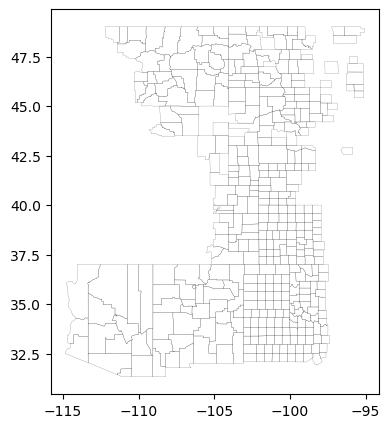

In [102]:
#| echo: false

# Plot the Shapefile to see the grid cells of interest
fig, ax = plt.subplots(figsize=(5, 5))
selected_counties_short.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.1)
# Display the plot
plt.show()

In [159]:
selected_counties_short.to_file("../testing_data/aws/spatial_data/grasscast_counties.geojson", driver='GeoJSON')

#### Grasscast Data

Grasscast forecast outputs can be accessed from the [https://grasscast.unl.edu/](https://grasscast.unl.edu/) website in CSV format. In the "Maps Archive" section, you can query based on date. To simplify the precess and access all available forecast data for the first time, we can automate the download with the following function.

In [42]:
def download_csv_as_dataframes(start_year=2020, end_year=date.today().year, region_code='gp'):
    base_url = "https://grasscast.unl.edu/data/csv/{year}/ANPP_forecast_summary_{region_code}_{year}_{month}_{day}.csv"
    dataframes = {}
    month_names = {4: "April", 5: "May", 6: "June", 7: "July", 8: "August", 9: "September"}
    for year in range(start_year, end_year + 1):
        for month in range(4, 10):  # From April to September
            # Setting the end day of the month
            if month in [4, 6, 9]:  # April, June, September have 30 days
                end_day = 30
            else:
                end_day = 31

            for day in range(1, end_day + 1):
                # Constructing the URL for each specific date
                url = base_url.format(year=year, region_code=region_code, month=month_names[month], day=day)
                print(url)
                try:
                    response = requests.get(url)
                    if response.status_code == 200:
                        # Reading the CSV into a Pandas dataframe
                        dataframe = pd.read_csv(url)
                        # Storing the dataframe with a key indicating the date
                        df_key = f"{year}_{month}_{day}"
                        dataframes[df_key] = dataframe
                        print(f"Data found and downloaded for date: {year}-{month}-{day}")
                    else:
                        print(f"No data available for date: {year}-{month}-{day}")
                except Exception as e:
                    print(f"Error downloading file for date: {year}-{month}-{day}, Error: {e}")

    return dataframes


Forecast for the Soith West has the forecast divided into two seasons, spring and summer, while the predictions for the Great Plains are summarized into a single season. Therefore, we will access and treat the data separatelly.

##### Forecast Data

###### Great Plains

####### Forecast Data access and wrangling

By applying the previous function, we will obtain a dictionary of dataframes, which will require further processing.

In [113]:
#| eval: false
#| output: false

# Downloading the available data using the function defined above
dataframes = download_csv_as_dataframes(region_code='gp')

https://grasscast.unl.edu/data/csv/2020/ANPP_forecast_summary_gp_2020_April_1.csv
No data available for date: 2020-4-1
https://grasscast.unl.edu/data/csv/2020/ANPP_forecast_summary_gp_2020_April_2.csv
No data available for date: 2020-4-2
https://grasscast.unl.edu/data/csv/2020/ANPP_forecast_summary_gp_2020_April_3.csv
Data found and downloaded for date: 2020-4-3
https://grasscast.unl.edu/data/csv/2020/ANPP_forecast_summary_gp_2020_April_4.csv
No data available for date: 2020-4-4
https://grasscast.unl.edu/data/csv/2020/ANPP_forecast_summary_gp_2020_April_5.csv
No data available for date: 2020-4-5
https://grasscast.unl.edu/data/csv/2020/ANPP_forecast_summary_gp_2020_April_6.csv
No data available for date: 2020-4-6
https://grasscast.unl.edu/data/csv/2020/ANPP_forecast_summary_gp_2020_April_7.csv
No data available for date: 2020-4-7
https://grasscast.unl.edu/data/csv/2020/ANPP_forecast_summary_gp_2020_April_8.csv
No data available for date: 2020-4-8
https://grasscast.unl.edu/data/csv/2020/

In [ ]:
#| echo: false

# # If needed, save the dataframes dictionary using pickle
# import pickle 
# with open('../testing_data/dataframes_gp_dict.pkl', 'wb') as f:
#     pickle.dump(dataframes, f)

From year to year, the variables have been stored with different names. Let's identify which columns are affected and rename them accordingly.

In [114]:
#| eval: false

def check_column_consistency(dataframes):
    shared_columns = set(dataframes[next(iter(dataframes))].columns)  # Initialize with columns of the first dataframe
    unique_columns = set()

    for df_key, df in dataframes.items():
        current_columns = set(df.columns)
        shared_columns = shared_columns.intersection(current_columns)  # Keep only columns that are shared
        unique_columns = unique_columns.union(current_columns.difference(shared_columns))  # Collect unique columns

    return list(shared_columns), list(unique_columns)

shared_cols, unique_cols = check_column_consistency(dataframes)

print("Shared columns:", shared_cols)
print("Unique columns:", unique_cols)

With the column names identified, let's rename them so that we can later merge the dataframes by column.

In [116]:
#| eval: false

def rename_dataframe_columns(dataframes_dict):
    rename_dict = {
        'NDVI_predict_2020_below': 'NDVI_predict_below',
        'NPP_predict_2020_below': 'NPP_predict_below',
        'NDVI_predict_2020_avg': 'NDVI_predict_avg',
        'NPP_predict_2020_avg': 'NPP_predict_avg',
        'NDVI_predict_2020_above': 'NDVI_predict_above',
        'NPP_predict_2020_above': 'NPP_predict_above',
        'NDVI_predict_2021_below': 'NDVI_predict_below',
        'NPP_predict_2021_below': 'NPP_predict_below',
        'NDVI_predict_2021_avg': 'NDVI_predict_avg',
        'NPP_predict_2021_avg': 'NPP_predict_avg',
        'NDVI_predict_2021_above': 'NDVI_predict_above',
        'NPP_predict_2021_above': 'NPP_predict_above'
    }

    for key, df in dataframes_dict.items():
        # Renaming the columns as per the rename_dict
        # Using inplace=True to modify the dataframe in place
        df.rename(columns={col: rename_dict[col] for col in df.columns if col in rename_dict}, inplace=True)

    return dataframes_dict

renamed_dataframes = rename_dataframe_columns(dataframes)
shared_cols, unique_cols = check_column_consistency(renamed_dataframes)

print("Shared columns:", shared_cols)
print("Unique columns:", unique_cols)

If we apply this, we can observe that there are still some unique columns not shared by all dataframes. Let's explore the dates associated with the remaining unique columns.

In [119]:
#| eval: false

def find_dataframes_with_columns(dataframes_dict, unique_columns):
    found_columns_in_dfs = {}

    for key, df in dataframes_dict.items():
        # Check if any of the unique columns are in the dataframe's columns
        found_columns = [col for col in unique_columns if col in df.columns]
        if found_columns:
            found_columns_in_dfs[key] = found_columns

    return found_columns_in_dfs

# Define the unique columns
unique_columns = ['PPTgs_avg', 'pptGSremainder_above', 'pptGSremainder_below', 
                  'pptAvgWatYrReceived', 'pptGSremainder_avg', 'PPTgs_below', 
                  'pptWatYrReceived', 'PPTgs_above']

# Usage
dataframes_with_unique_columns = find_dataframes_with_columns(renamed_dataframes, unique_columns)
for key, cols in dataframes_with_unique_columns.items():
    print(f"DataFrame Key: {key}")


DataFrame Key: 2022_4_5
DataFrame Key: 2022_4_19
DataFrame Key: 2022_5_3
DataFrame Key: 2022_5_17
DataFrame Key: 2022_5_31
DataFrame Key: 2022_6_14
DataFrame Key: 2022_6_28
DataFrame Key: 2022_7_12
DataFrame Key: 2022_7_26
DataFrame Key: 2022_8_9
DataFrame Key: 2022_8_23
DataFrame Key: 2022_9_1
DataFrame Key: 2023_4_4
DataFrame Key: 2023_4_18
DataFrame Key: 2023_5_2
DataFrame Key: 2023_5_16
DataFrame Key: 2023_5_31
DataFrame Key: 2023_6_13
DataFrame Key: 2023_6_27
DataFrame Key: 2023_7_11
DataFrame Key: 2023_7_25
DataFrame Key: 2023_8_22
DataFrame Key: 2023_9_6


As we can see, these columns are not shared by all of the forecast data for different years. Since our only interest is in the ANPP, we will proceed to remove these columns.

In [120]:
#| eval: false

def discard_columns_from_dataframes(dataframes_dict, columns_to_discard):
    for key, df in dataframes_dict.items():
        # Dropping the specified columns if they exist in the dataframe
        df.drop(columns=[col for col in columns_to_discard if col in df.columns], inplace=True, errors='ignore')

    return dataframes_dict

# Define the columns to discard
unique_columns = ['PPTgs_avg', 'pptGSremainder_above', 'pptGSremainder_below', 
                  'pptAvgWatYrReceived', 'pptGSremainder_avg', 'PPTgs_below', 
                  'pptWatYrReceived', 'PPTgs_above']

# Usage 
cleaned_dataframes_dict = discard_columns_from_dataframes(renamed_dataframes, unique_columns)
shared_cols, unique_cols = check_column_consistency(cleaned_dataframes_dict)
print("Shared columns:", shared_cols)
print("Unique columns:", unique_cols)

Now that we have the datasets with the variables of interest, before combining all dataframes into a single one, let's add a variable 'report_date' containing the date of the CSV report.

In [122]:
#| eval: false

def add_report_date_to_dataframes(dataframes_dict):
    for key, df in dataframes_dict.items():
        # Parsing the key to construct the date in 'yyyy-mm-dd' format
        year, month, day = key.split('_')
        report_date = f"{year}-{month.zfill(2)}-{day.zfill(2)}"  # ensuring month and day are two digits

        # Adding the new column 'report_date' to the dataframe
        df['report_date'] = report_date

    return dataframes_dict

cleaned_dataframes_dict_with_dates =add_report_date_to_dataframes(cleaned_dataframes_dict)

Now, with the dataframes cleaned, let's join them into a single dataframe and save it as a CSV.

In [124]:
#| eval: false

def combine_dataframes(dataframes_dict):
    # Extract all dataframes into a list
    dfs = list(dataframes_dict.values())

    # Combine dataframes, keeping only common columns
    combined_df = pd.concat(dfs, join='inner', ignore_index=True)

    return combined_df

# Usage
combined_dataframe = combine_dataframes(cleaned_dataframes_dict_with_dates)

Once we are done, we can save it, but before, we should standardize the column names.

In [125]:
#| eval: false

combined_dataframe = combined_dataframe.clean_names()

In [126]:
#| eval: false
#| echo: false

combined_dataframe.to_csv('../testing_data/aws/gp/forecast_data_grasscast_gp.csv', index=False)

###### Southwest

The same procedure will apply to the SW data with slight differences due to different variable names.

In [ ]:
#| eval: false
#| output: false

# Downloading the available data using the function defined above
dataframes = download_csv_as_dataframes(region_code='sw')

https://grasscast.unl.edu/data/csv/2020/ANPP_forecast_summary_sw_2020_April_1.csv
Data found and downloaded for date: 2020-4-1
https://grasscast.unl.edu/data/csv/2020/ANPP_forecast_summary_sw_2020_April_2.csv
No data available for date: 2020-4-2
https://grasscast.unl.edu/data/csv/2020/ANPP_forecast_summary_sw_2020_April_3.csv
No data available for date: 2020-4-3
https://grasscast.unl.edu/data/csv/2020/ANPP_forecast_summary_sw_2020_April_4.csv
No data available for date: 2020-4-4
https://grasscast.unl.edu/data/csv/2020/ANPP_forecast_summary_sw_2020_April_5.csv
No data available for date: 2020-4-5
https://grasscast.unl.edu/data/csv/2020/ANPP_forecast_summary_sw_2020_April_6.csv
No data available for date: 2020-4-6
https://grasscast.unl.edu/data/csv/2020/ANPP_forecast_summary_sw_2020_April_7.csv
No data available for date: 2020-4-7
https://grasscast.unl.edu/data/csv/2020/ANPP_forecast_summary_sw_2020_April_8.csv
No data available for date: 2020-4-8
https://grasscast.unl.edu/data/csv/2020/

In [ ]:
#| eval: false
#| echo: false

# # If needed, save the dataframes dictionary using pickle
# import pickle 
# with open('../testing_data/aws/sw/dataframes_sw_dict.pkl', 'wb') as f:
#     pickle.dump(dataframes, f)

We can use the previously defined function to identify variables that have been stored with distinct names.

In [ ]:
#| eval: false

shared_cols, unique_cols = check_column_consistency(dataframes)
print("Shared columns:", shared_cols)
print("Unique columns:", unique_cols)


Shared columns: ['meanANPPgrid', 'pct_diffNPP_avg', 'deltaNPP_below', 'Indx', 'NPP_stdev_below', 'deltaNPP_avg', 'meanNDVIgrid', 'Fips', 'NPP_stdev_avg', 'pct_diffNPP_below', 'CountyState', 'pct_diffNPP_above', 'deltaNPP_above', 'gridID', 'Year', 'NPP_stdev_above']
Unique columns: ['NDVI_predict_2021_above', 'NPP_predict_2021_above', 'pptAvgJunReceived', 'NPP_predict_avg', 'NPP_predict_2021_avg', 'pptGSremainder_below', 'NDVI_predict_2021_below', 'pptWatYrReceived', 'pptAvgWatYrReceived', 'PPTgs_below', 'pptGSremainder_above', 'NPP_predict_above', 'NDVI_predict_avg', 'NDVI_predict_above', 'NPP_predict_2021_below', 'PPTgs_avg', 'NDVI_predict_2021_avg', 'pptGSremainder_avg', 'pptJunReceived', 'NDVI_predict_below', 'NPP_predict_below', 'PPTgs_above']


With the column names identified, we will see that they differ from the previous ones. With this information, let's proceed to rename them, making it easier for us to merge the dataframes by column later on.

In [ ]:
#| eval: false

def rename_dataframe_columns(dataframes_dict):
    rename_dict = {
        'NDVI_predict_2019_below': 'NDVI_predict_below',
        'NPP_predict_2019_below': 'NPP_predict_below',
        'NDVI_predict_2019_avg': 'NDVI_predict_avg',
        'NPP_predict_2019_avg': 'NPP_predict_avg',
        'NDVI_predict_2019_above': 'NDVI_predict_above',
        'NPP_predict_2019_above': 'NPP_predict_above',
        'NDVI_predict_2020_below': 'NDVI_predict_below',
        'NPP_predict_2020_below': 'NPP_predict_below',
        'NDVI_predict_2020_avg': 'NDVI_predict_avg',
        'NPP_predict_2020_avg': 'NPP_predict_avg',
        'NDVI_predict_2020_above': 'NDVI_predict_above',
        'NPP_predict_2020_above': 'NPP_predict_above',
        'NDVI_predict_2021_below': 'NDVI_predict_below',
        'NPP_predict_2021_below': 'NPP_predict_below',
        'NDVI_predict_2021_avg': 'NDVI_predict_avg',
        'NPP_predict_2021_avg': 'NPP_predict_avg',
        'NDVI_predict_2021_above': 'NDVI_predict_above',
        'NPP_predict_2021_above': 'NPP_predict_above'
    }

    for key, df in dataframes_dict.items():
        # Renaming the columns as per the rename_dict
        # Using inplace=True to modify the dataframe in place
        df.rename(columns={col: rename_dict[col] for col in df.columns if col in rename_dict}, inplace=True)

    return dataframes_dict

renamed_dataframes = rename_dataframe_columns(dataframes)
shared_cols, unique_cols = check_column_consistency(renamed_dataframes)
print("Shared columns:", shared_cols)
print("Unique columns:", unique_cols)

There are still some distict columns not shared by all dataframes. Let's check the dates associated with these.

In [ ]:
#| eval: false

def find_dataframes_with_columns(dataframes_dict, unique_columns):
    found_columns_in_dfs = {}

    for key, df in dataframes_dict.items():
        # Check if any of the unique columns are in the dataframe's columns
        found_columns = [col for col in unique_columns if col in df.columns]
        if found_columns:
            found_columns_in_dfs[key] = found_columns

    return found_columns_in_dfs

# Define the unique columns
unique_columns = ['PPTgs_avg', 'pptAvgJunReceived', 'pptGSremainder_below', 'pptGSremainder_avg',
                   'pptWatYrReceived', 'pptAvgWatYrReceived', 'PPTgs_below', 'pptGSremainder_above',
                    'pptJunReceived', 'PPTgs_above']

# Usage
dataframes_with_unique_columns = find_dataframes_with_columns(renamed_dataframes, unique_columns)
for key, cols in dataframes_with_unique_columns.items():
    print(f"DataFrame Key: {key}")


DataFrame Key: 2022_4_5
DataFrame Key: 2022_4_19
DataFrame Key: 2022_5_3
DataFrame Key: 2022_5_17
DataFrame Key: 2022_5_31
DataFrame Key: 2022_6_14
DataFrame Key: 2022_6_28
DataFrame Key: 2022_7_12
DataFrame Key: 2022_7_26
DataFrame Key: 2022_8_9
DataFrame Key: 2022_8_23
DataFrame Key: 2022_9_1
DataFrame Key: 2023_4_4
DataFrame Key: 2023_4_18
DataFrame Key: 2023_5_2
DataFrame Key: 2023_5_16
DataFrame Key: 2023_5_31
DataFrame Key: 2023_6_13
DataFrame Key: 2023_6_27
DataFrame Key: 2023_7_11
DataFrame Key: 2023_7_25
DataFrame Key: 2023_8_22
DataFrame Key: 2023_9_6


Running the previous function, we can observe that these columns are not shared among all the forecast data for different years. Since our only interest is in the ANPP, we will proceed to remove these columns.

In [ ]:
#| eval: false

def discard_columns_from_dataframes(dataframes_dict, columns_to_discard):
    for key, df in dataframes_dict.items():
        # Dropping the specified columns if they exist in the dataframe
        df.drop(columns=[col for col in columns_to_discard if col in df.columns], inplace=True, errors='ignore')

    return dataframes_dict

# Define the columns to discard
unique_columns = ['PPTgs_avg', 'pptAvgJunReceived', 'pptGSremainder_below', 'pptGSremainder_avg',
                   'pptWatYrReceived', 'pptAvgWatYrReceived', 'PPTgs_below', 'pptGSremainder_above',
                    'pptJunReceived', 'PPTgs_above']

# Usage 
cleaned_dataframes_dict = discard_columns_from_dataframes(renamed_dataframes, unique_columns)
shared_cols, unique_cols = check_column_consistency(cleaned_dataframes_dict)
print("Shared columns:", shared_cols)
print("Unique columns:", unique_cols)

Now, let's proceed with the remaining processing steps, which involve adding the report date, combining the data, and standardizing the dataset.

In [ ]:
#| eval: false

cleaned_dataframes_dict_with_dates =add_report_date_to_dataframes(cleaned_dataframes_dict)
combined_dataframe = combine_dataframes(cleaned_dataframes_dict_with_dates)
combined_dataframe = combined_dataframe.clean_names()


In [ ]:
#| eval: false
#| echo: false

combined_dataframe.to_csv('../testing_data/aws/sw/forecast_data_grasscast_sw.csv', index=False)

##### Historic Data

The complete historic series is not available on the Grasscast website. These were obtained upon request from the Grasscast team. This section explores the data and processes it so that it can be used in the application.

###### Great Plains

Working with the GP dataset, let's first standardize the column names before proceeding further.

In [110]:
#| echo: false

hist_grasscast_gp = pd.read_csv("../testing_data/aws/gp/hist_data_grasscast_gp.csv")

In [111]:
hist_grasscast_gp = hist_grasscast_gp.clean_names()
def remove_trailing_underscores(name):
    return name.rstrip('_')
hist_grasscast_gp.columns = [remove_trailing_underscores(col) for col in hist_grasscast_gp.columns]
hist_grasscast_gp.columns

Index(['fips', 'gridid', 'countyst', 'latitude', 'longitude', 'year',
       'pptamjj_cm', 'pptamjja_cm', 'aetamjj_cm', 'aetamjja_cm', 'anpp_lbs_ac',
       'pptamjj_mean_cm', 'pptamjja_mean_cm', 'aetamjj_mean_cm',
       'aetamjja_mean_cm', 'anpp_mean_lbs_ac', 'anpp_percent_diff_%'],
      dtype='object')

In [10]:
hist_grasscast_gp['year'].unique()

array([1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
       1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017, 2018, 2019])

While exploring the years, we can observe that there is data available up to 2019. Therefore, we will have to add the last recorded values for each remaining year from the forecast dataframe created earlier. We will follow this approach for all years except for the last available year. For the last available year, its values will need to be correlated against the expected climate for the season.

In [104]:
#| echo: false

forecast_grasscast_gp = pd.read_csv("../testing_data/aws/gp/forecast_data_grasscast_gp.csv")

In [105]:
# Convert 'report_date' to datetime
forecast_grasscast_gp['report_date'] = pd.to_datetime(forecast_grasscast_gp['report_date'])
# Group by 'Year' and get the last 'report_date'
max_dates_per_year = forecast_grasscast_gp.groupby('year')['report_date'].max()
print(max_dates_per_year)

year
2020   2020-09-01
2021   2021-08-24
2022   2022-09-01
2023   2023-09-06
Name: report_date, dtype: datetime64[ns]


In [108]:
# Merge to get only the observations on the last report date of each year
result = pd.merge(forecast_grasscast_gp, max_dates_per_year, on=['year', 'report_date'])
# Selecting only the specified columns
result["anpp_lbs_ac"] = result[["npp_predict_below", "npp_predict_avg", "npp_predict_above"]].mean(axis=1)
# Printing the selected columns
result[["gridid","year","anpp_lbs_ac","npp_predict_below", "npp_predict_avg", "npp_predict_above"]].head()

,gridid,year,anpp_lbs_ac,npp_predict_below,npp_predict_avg,npp_predict_above
0,74844,2020,631.1814,631.1814,631.1814,631.1814
1,74845,2020,626.9868,626.9868,626.9868,626.9868
2,74846,2020,635.6654,635.6654,635.6654,635.6654
3,74847,2020,638.6883,638.6883,638.6883,638.6883
4,74848,2020,644.6118,644.6118,644.6118,644.6118


Combine the variables of interest into a single dataframe to be read in the app.

In [112]:
# Select the specified columns from hist_grasscast_gp
selected_columns_hist = hist_grasscast_gp[["gridid", "year", "anpp_lbs_ac"]]
selected_columns_forecast = result[["gridid", "year", "anpp_lbs_ac"]]
combined_df = pd.concat([selected_columns_hist, selected_columns_forecast], ignore_index=True)
combined_df.head()


,gridid,year,anpp_lbs_ac
0,74844,1982,843.26
1,74844,1983,1066.65
2,74844,1984,775.78
3,74844,1985,870.02
4,74844,1986,748.74


Before saving it, we will exclude the overlapping cells with the SW area and remove the observations for the last available year, which will be updated later.

In [17]:
#| echo: false

overlapping_ids = pd.read_json("../testing_data/aws/spatial_data/overlapping_gridids.json")

In [18]:
# Convert the 'gridid' in overlapping_ids to a set for faster lookup
overlapping_ids_set = set(overlapping_ids['gridid'])
# Create a boolean index for rows in combined_df where 'gridid' is not in overlapping_ids_set
non_overlapping_index = ~combined_df['gridid'].isin(overlapping_ids_set)
# Filter the combined_df using this index
filtered_combined_df = combined_df[non_overlapping_index]
# Remove rows where 'year' is 2023
filtered_combined_df = filtered_combined_df[filtered_combined_df['year'] != 2023]

In [28]:
#| echo: false

filtered_combined_df.to_csv('../testing_data/aws/gp/updated_hist_data_grasscast_gp.csv', index=False)

###### Southwest

We will apply the same procedure to the SW data.

In [117]:
#| echo: false

hist_grasscast_sw = pd.read_csv("../testing_data/aws/sw/hist_data_grasscast_sw.csv")
forecast_grasscast_sw = pd.read_csv("../testing_data/aws/sw/forecast_data_grasscast_sw.csv")

In [118]:
hist_grasscast_sw = hist_grasscast_sw.clean_names()
hist_grasscast_sw.columns = [remove_trailing_underscores(col) for col in hist_grasscast_sw.columns]

The historical forecast data for SW has the predictions divided into two seasons: spring and summer. Therefore, here we will treat the values from April to June differently from those for the following months.

In [119]:
# Convert the 'Date' column to datetime if it's not
forecast_grasscast_sw['report_date'] = pd.to_datetime(forecast_grasscast_sw['report_date'])
# Filter the dataframe for the last day of May and the last day of the year
last_day_may = forecast_grasscast_sw[forecast_grasscast_sw['report_date'].dt.month == 5].groupby('year')['report_date'].max()
last_day_year = forecast_grasscast_sw.groupby('year')['report_date'].max()
# Group by 'Year' and get the last 'report_date'
max_dates_per_year = pd.concat([last_day_may, last_day_year])
print(max_dates_per_year)

year
2020   2020-05-15
2021   2021-05-18
2022   2022-05-31
2023   2023-05-31
2020   2020-09-01
2021   2021-08-24
2022   2022-09-01
2023   2023-09-06
Name: report_date, dtype: datetime64[ns]


In [123]:
result = pd.merge(forecast_grasscast_sw, max_dates_per_year, on=['year', 'report_date'])
# Add a new column to classify the report_date into 'spring' or 'summer'
# Extract the month from report_date
result['month'] = pd.to_datetime(result['report_date']).dt.month
# Assign 'spring' or 'summer' based on the month
result['season'] = result['month'].apply(lambda x: 'spring' if 4 <= x < 6 else 'summer')
# Calculate mean values for spring and summer separately
result['predicted_spring_anpp_lbs_ac'] = result.apply(lambda row: row[["npp_predict_below", "npp_predict_avg", "npp_predict_above"]].mean() if row['season'] == 'spring' else None, axis=1)
result['predicted_summer_anpp_lbs_ac'] = result.apply(lambda row: row[["npp_predict_below", "npp_predict_avg", "npp_predict_above"]].mean() if row['season'] == 'summer' else None, axis=1)
# Drop the temporary columns if not needed
result = result.drop(['month', 'season'], axis=1)

# Select the specified columns from hist_grasscast_gp
selected_columns_hist = hist_grasscast_sw[["gridid", "year", "predicted_spring_anpp_lbs_ac", "predicted_summer_anpp_lbs_ac"]]
selected_columns_forecast = result[["gridid", "year", "predicted_spring_anpp_lbs_ac", "predicted_summer_anpp_lbs_ac"]]
# Create a final dataframe with the historical dataframe structure
merged_selected_columns_forecast = selected_columns_forecast.groupby(['gridid', 'year'], as_index=False).first()
# Combine the formated forecast dataframe with the historical dataframe
combined_df = pd.concat([selected_columns_hist, merged_selected_columns_forecast], ignore_index=True)
# Exclude last year observations
combined_df = combined_df[combined_df['year'] != 2023]
combined_df.head()

,gridid,year,predicted_spring_anpp_lbs_ac,predicted_summer_anpp_lbs_ac
0,45748,1982,336.29,489.48
1,45748,1983,332.46,601.13
2,45748,1984,331.40,569.19
3,45748,1985,343.90,512.03
4,45748,1986,329.19,544.87


In [ ]:
#| echo: false

combined_df.to_csv('../testing_data/aws/sw/updated_hist_data_grasscast_sw.csv', index=False)

#### Climate data & forecast corrections

To determine which of the ANPP projections is more likely to occur, GrassCast redirects us to the NOAA Climate Prediction Center ([https://www.cpc.ncep.noaa.gov/products/predictions/long_range/interactive/index.php](https://www.cpc.ncep.noaa.gov/products/predictions/long_range/interactive/index.php) ). There, we can check the monthly and seasonal precipitation outlooks. The function below is used to streamline the data access and download the shapefile containing the precipitation outlooks. 


In [ ]:
def clear_directory(path):
    for file in os.listdir(path):
        file_path = os.path.join(path, file)
        if os.path.isfile(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            # Recursively clear and delete the subdirectory
            clear_directory(file_path)
            os.rmdir(file_path)

def download_and_extract_seasprcp_files(year, month, save_path):
    # Check if the month is between April and July
    if month < 4 or month > 7:
        return "No download required. Month is not between April and July."

    base_url = 'https://ftp.cpc.ncep.noaa.gov/GIS/us_tempprcpfcst/'
    filename = 'seasprcp_{0:04d}{1:02d}.zip'.format(year, month)
    url = base_url + filename

    try:
        # Ensure the save_path directory exists and is empty
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        else:
            clear_directory(save_path)

        # Download the ZIP file
        response = requests.get(url)
        response.raise_for_status()

        # Save the ZIP file temporarily
        temp_zip_path = os.path.join(save_path, filename)
        with open(temp_zip_path, 'wb') as f:
            f.write(response.content)

        # Extract only files starting with 'lead1'
        with zipfile.ZipFile(temp_zip_path, 'r') as zip_ref:
            for file in zip_ref.namelist():
                if file.startswith('lead1_'):
                    zip_ref.extract(file, save_path)

        # Optionally, remove the ZIP file after extraction
        os.remove(temp_zip_path)

        return "Files starting with 'lead1' extracted successfully."

    except requests.exceptions.HTTPError as err:
        return "HTTP Error: " + str(err)
    except zipfile.BadZipFile:
        return "Error: The downloaded file is not a zip file."
    except Exception as e:
        return "Error: " + str(e)
    
seasprcp_shp_path = '../testing_data/aws/climate_data/seasprcp/'
download_and_extract_seasprcp_files(2023, 6, seasprcp_shp_path)

Upon examining the data, you will notice that different areas have different classifications for below-average and above-normal precipitation conditions. These classifications are accompanied by associated probabilities of occurrence.

In [5]:
# Read downloaded shapefile
seasprcp_202306_shp_path = '../testing_data/aws/climate_data/seasprcp/lead1_JAS_prcp.shp'
seasprcp_202306_raw = gpd.read_file(seasprcp_202306_shp_path).to_crs(epsg=4326)
# Transforming probabikity variable to account for all decimals
seasprcp_202306_raw['Prob'] = seasprcp_202306_raw['Prob'].apply(lambda x: (1/3)*100 if x == 33.0 else x)
seasprcp_202306_raw.head()

,Fcst_Date,Valid_Seas,Prob,Cat,InPoly_FID,SmoPgnFlag,geometry
0,2023-06-15,JAS 2023,33.333333,Above,2,0,"MULTIPOLYGON (((-80.35567 25.15823, -80.58782 ..."
1,2023-06-15,JAS 2023,33.333333,Above,8,0,"POLYGON ((-96.24742 43.49909, -95.75420 43.080..."
2,2023-06-15,JAS 2023,40.000000,Above,3,0,"POLYGON ((-97.12998 36.53516, -97.48238 36.518..."
3,2023-06-15,JAS 2023,33.333333,Below,5,0,"MULTIPOLYGON (((-122.52575 48.32104, -122.5286..."
4,2023-06-15,JAS 2023,33.333333,Below,7,0,"POLYGON ((-106.42924 36.60653, -106.26840 36.1..."



Upon further evaluation of the data and the information available at the NCEP (National Centers for Environmental Prediction), it has been observed that regions with an expected average precipitation (EC) are associated with equal chances for each class. This means that the probabilities for above average, below average, and average precipitation are each 33.33%. Additionally, the EC probability is always 33.33%. Therefore, for instance, any area falling within the "above" classification, the EC probability will be 33%, and the below-average probability will be equal to 100% minus the sum of the EC and above-average probabilities. This will help us defining the expected ANPP from the GrassCast scenarios.

##### Incorporate Climate Outlooks to Grasscast grid

The climate outlooks are represented by polygons with variable shapes. To select the ANPP corresponding to one of the three scenarios, we need to correlate it with a climate scenario at a cell grid level. This can be achieved by applying an attribute join by location and saving the information contained in the variable 'Cat', which specifies the expected climate anomaly, to our grid of interest.

In [3]:
#| echo: false

grasscast_aoi_grid_path = '../testing_data/aws/spatial_data/grasscast_aoi_grid.geojson'
grasscast_aoi_grid = gpd.read_file(grasscast_aoi_grid_path).to_crs(epsg=4326)

In [6]:
def join_attributes_by_largest_overlap(southwest_grid_raw, precip_grid_raw):
   # Overlay by intersection
   intersection = gpd.overlay(southwest_grid_raw, precip_grid_raw, how='intersection')
   # Create a new column for the area
   intersection['area'] = intersection.geometry.area
   # Sort by area so largest area is last
   intersection.sort_values(by='area', inplace=True)
   # Drop duplicates, keep last/largest
   intersection.drop_duplicates(subset='gridid', keep='last', inplace=True)
   # Merge Cat by Id
   joined = southwest_grid_raw.merge(intersection[['gridid','Cat','Prob']], left_on='gridid', right_on='gridid').clean_names()
   return joined

seasprcp_202306_swgrid = join_attributes_by_largest_overlap(grasscast_aoi_grid, seasprcp_202306_raw)
seasprcp_202306_swgrid[['gridid','cat','prob']].head()

/var/folders/j9/3pt402nn3fj0ykg4t_f43_c40000gn/T/ipykernel_2882/1438613503.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  intersection['area'] = intersection.geometry.area


,gridid,cat,prob
0,33406,Above,33.333333
1,33407,Above,33.333333
2,33408,Above,33.333333
3,33867,Above,33.333333
4,33868,Above,33.333333


To determine the most probable forecast outcome, the following subsections will incorporate climate data into each observation within the forecast dataset.

##### Southwest


In [25]:
#| echo: false

grasscast_forecast_sw = pd.read_csv("../testing_data/aws/sw/forecast_data_grasscast_sw.csv")

In [26]:
grasscast_2023_forecast_sw = grasscast_forecast_sw[grasscast_forecast_sw['year'] == 2023]
# Merge based on Id
merged_df = pd.merge(grasscast_2023_forecast_sw, seasprcp_202306_swgrid[['gridid', 'cat', 'prob']], 
                     left_on='gridid', right_on='gridid', how='left')

Once the NOAA climate data is available in the forecast dataset, it is possible to calculate the expected forecast associated with the ANPP scenarios and determine the expected precipitation scenario for each grid cell. By incorporating the NOAA climate data, we can obtain am ANPP value based on the corresponding precipitation scenarios for each cell.

In [27]:
def calculate_NPP_predict_clim(row):
    Cat = row['cat']
    Prob = row['prob']
    NPP_predict_below = row['npp_predict_below']
    NPP_predict_above = row['npp_predict_above']
    NPP_predict_avg = row['npp_predict_avg']

    if Cat == 'EC':
        return NPP_predict_below * (1/3) + NPP_predict_avg * (1/3) + NPP_predict_above * (1/3)
    else:
        # Calculate remaining_prob
        remaining_prob = 1 - ((Prob / 100) + (1/3))
    
        if Cat == 'Below':
            return (NPP_predict_below * (Prob / 100)) + NPP_predict_avg * (1/3) + NPP_predict_above * remaining_prob
        elif Cat == 'Above':
            return (NPP_predict_above * (Prob / 100)) + NPP_predict_avg * (1/3) + NPP_predict_below * remaining_prob
        
merged_df['npp_predict_clim'] = merged_df.apply(calculate_NPP_predict_clim, axis=1)

In [307]:
#| echo: false

merged_df.to_csv("../testing_data/aws/sw/forecast_data_grasscast_sw_clim.csv")

####### Adding climate corrected data to historical series

In [42]:
#| echo: false

hist_sw = pd.read_csv("../testing_data/aws/sw/updated_hist_data_grasscast_sw.csv")
forecast_sw = pd.read_csv("../testing_data/aws/sw/forecast_data_grasscast_sw_clim.csv")

As previously mentioned, we excluded the last/current year's forecast from the historical series, as it needs to be initially compared with the climate outlooks. Consequently, we will now add the previously calculated expected ANPP to that dataframe, which was missing one year."

In [43]:
hist_sw["year"].unique()

array([1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
       1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022])

In [45]:
# Convert the 'report_date' column to datetime if it's not
forecast_sw['report_date'] = pd.to_datetime(forecast_sw['report_date'])

# Filter the dataframe for the last day of May and the last day of the year
last_day_may = forecast_sw[forecast_sw['report_date'].dt.month == 5].groupby('year')['report_date'].max()
last_day_year = forecast_sw.groupby('year')['report_date'].max()

# Group by 'year' and get the last 'report_date'
max_dates_per_year = pd.concat([last_day_may, last_day_year])

# Merge the DataFrames
result = pd.merge(forecast_sw, max_dates_per_year, on=['year', 'report_date'])

# Extract the month from report_date
result['month'] = pd.to_datetime(result['report_date']).dt.month

# Assign 'spring' or 'summer' based on the month
result['season'] = result['month'].apply(lambda x: 'spring' if 4 <= x < 6 else 'summer')

# Assign the value from npp_predict_clim to predicted_spring_anpp_lbs_ac or predicted_summer_anpp_lbs_ac
result['predicted_spring_anpp_lbs_ac'] = result.apply(lambda row: row['npp_predict_clim'] if row['season'] == 'spring' else None, axis=1)
result['predicted_summer_anpp_lbs_ac'] = result.apply(lambda row: row['npp_predict_clim'] if row['season'] == 'summer' else None, axis=1)

# Select the specified columns from hist_grasscast_gp
selected_columns_hist = hist_sw[["gridid", "year", "predicted_spring_anpp_lbs_ac", "predicted_summer_anpp_lbs_ac"]]
selected_columns_forecast = result[["gridid", "year", "predicted_spring_anpp_lbs_ac", "predicted_summer_anpp_lbs_ac"]]
merged_selected_columns_forecast = selected_columns_forecast.groupby(['gridid', 'year'], as_index=False).first()
df_hist_sw = pd.concat([selected_columns_hist, merged_selected_columns_forecast], ignore_index=True)
df_hist_sw["year"].unique()

array([1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
       1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023])

##### Great Plains


We will apply a similar procedure to the GP data, with slight variations due to the fact that it only contains forecast data for a single season.

In [35]:
#| echo: false

grasscast_forecast_gp = pd.read_csv("../testing_data/aws/gp/forecast_data_grasscast_gp.csv")
overlapping_ids = pd.read_json("../testing_data/aws/spatial_data/overlapping_gridids.json")

In [36]:
grasscast_2023_forecast_gp = grasscast_forecast_gp[grasscast_forecast_gp['year'] == 2023]
# Convert the 'gridid' in overlapping_ids to a set for faster lookup
overlapping_ids_set = set(overlapping_ids['gridid'])
# Create a boolean index for rows in combined_df where 'gridid' is not in overlapping_ids_set
non_overlapping_index = ~grasscast_2023_forecast_gp['gridid'].isin(overlapping_ids_set)
# Filter the combined_df using this index
filtered_combined_df = grasscast_2023_forecast_gp[non_overlapping_index]
# Merge based on Id
merged_df = pd.merge(filtered_combined_df, seasprcp_202306_swgrid[['gridid', 'cat', 'prob']], 
                     left_on='gridid', right_on='gridid', how='left')
# Apply climate correlation function
merged_df['npp_predict_clim'] = merged_df.apply(calculate_NPP_predict_clim, axis=1)


In [40]:
#| echo: false

merged_df.to_csv("../testing_data/aws/gp/forecast_data_grasscast_gp_clim.csv")
hist_gp = pd.read_csv("../testing_data/aws/gp/updated_hist_data_grasscast_gp.csv")
forecast_gp = pd.read_csv("../testing_data/aws/gp/forecast_data_grasscast_gp_clim.csv")

In [41]:
# Convert the 'Date' column to datetime if it's not
forecast_gp['report_date'] = pd.to_datetime(forecast_gp['report_date'])

# Filter the dataframe for the last day of the year
max_dates_per_year = forecast_gp.groupby('year')['report_date'].max()

# Merge the DataFrames
result = pd.merge(forecast_gp, max_dates_per_year, on=['year', 'report_date'])

# Assign the value from npp_predict_clim to anpp_lbs_ac or predicted_summer_anpp_lbs_ac
result['anpp_lbs_ac'] = result.apply(lambda row: row['npp_predict_clim'], axis=1)

# Select the specified columns from hist_grasscast_gp
selected_columns_hist = hist_gp[["gridid", "year", "anpp_lbs_ac"]]
selected_columns_forecast = result[["gridid", "year", "anpp_lbs_ac"]]
merged_selected_columns_forecast = selected_columns_forecast.groupby(['gridid', 'year'], as_index=False).first()
df_hist_gp = pd.concat([selected_columns_hist, merged_selected_columns_forecast], ignore_index=True)

##### Combining SW and GP data


In [49]:
## CONCATENATE GP AND SW
df_hist = pd.concat([df_hist_sw, df_hist_gp], ignore_index=True)
df_forecast = pd.concat([forecast_sw, forecast_gp], ignore_index=True)

df_hist.to_csv("../testing_data/aws/hist_data_grasscast_gp_sw.csv")
df_forecast.to_csv("../testing_data/aws/forecast_data_grasscast_gp_sw.csv")

### Market data


An interesting feature that has been added to the application is the ability to access real-time market data, specifically cattle and hay prices sourced from USDA Market News services. The USDA provides free access to the My Market News API, which is a powerful tool for developers and analysts. It offers customized market data feeds and integration capabilities for various systems or applications.

More information here: [https://mymarketnews.ams.usda.gov/mars-api/getting-started](https://mymarketnews.ams.usda.gov/mars-api/getting-started)

Before incorporating the data into the app, we conducted a preliminary API exploration to understand its contents and data structure.

#### MyMarketNews API exploration

MyMarketNews API allows access all range of data including updated livestoock data. For teachnical instructions and how to create an acces account visit [https://mymarketnews.ams.usda.gov/mars-api/getting-started/technical-instructions](https://mymarketnews.ams.usda.gov/mars-api/getting-started/technical-instructions)

Below is the function that facilitates the API connection:

In [46]:
def get_data_from_marsapi(api_key, endpoint):
    base_url = "https://marsapi.ams.usda.gov"
    response = requests.get(base_url + endpoint, auth=(api_key, ''))
    if response.status_code == 200:
        return response.json()
    else:
        response.raise_for_status()

api_key = open("foodsight-app/.mmn_api_token").read() 


Let's explore the market types included in the API

In [47]:
endpoint = "/services/v1.2/marketTypes" 
data = get_data_from_marsapi(api_key, endpoint)
pd.DataFrame(data).head()

,market_type_id,market_type
0,1029,Auction Hay
1,1000,Auction Livestock
2,1013,Auction Livestock (Board Sale)
3,1010,Auction Livestock (Imported)
4,1012,Auction Livestock (Special Graded)


We are interested in Auction Livestock with id 1000. Let's explore what markets are included.

In [60]:
endpoint = "/services/v1.2/marketTypes/1000" # 1000 is the market type ID for Auction Livestock
data = get_data_from_marsapi(api_key, endpoint)
df = pd.DataFrame(data)
print("columns:", df.columns)
print("")
print("markets: ",pd.Series([item for sublist in df['markets'] for item in sublist]).unique()[0:9])

columns: Index(['slug_id', 'slug_name', 'report_title', 'report_date', 'published_date',
       'report_status', 'markets', 'market_types', 'offices',
       'hasCorrectionsInLastThreeDays', 'sectionNames'],
      dtype='object')

markets:  ['Unionville Livestock Market LLC' 'Joplin Regional Stockyards'
 'New Cambria Livestock Market' 'Ozarks Regional Stockyards'
 'Green City Livestock Auction' 'Springfield Livestock Marketing Center'
 'Oklahoma National Stockyards Market' 'OKC West Livestock Market'
 'Columbia Livestock Market']


We can search for a specific market and retrieve its ID to access cattle data for that market.

In [53]:
df[df['markets'].apply(lambda x: "Cattlemen's Livestock Auction - Belen, NM" in x)]

,slug_id,slug_name,report_title,report_date,published_date,report_status,markets,market_types,offices,hasCorrectionsInLastThreeDays,sectionNames
35,1783,AMS_1783,"Cattlemen's Livestock Auction - Belen, NM",01/26/2024,01/26/2024 19:53:39,Final,"[Cattlemen's Livestock Auction - Belen, NM]",[Auction Livestock],"[Portales, NM]",False,[]


By using the slug_id for Cattlemen's Livestock Auction in Belen, NM, we can access the available data for cattle markets.

In [65]:
endpoint = "/services/v1.2/reports/1783"
data = get_data_from_marsapi(api_key, endpoint)
df = pd.DataFrame(data['results'])
df.columns

Index(['report_date', 'report_begin_date', 'report_end_date', 'published_date',
       'office_name', 'office_state', 'office_city', 'office_code',
       'market_type', 'market_type_category', 'market_location_name',
       'market_location_state', 'market_location_city', 'slug_id', 'slug_name',
       'report_title', 'group', 'category', 'commodity', 'class', 'frame',
       'muscle_grade', 'quality_grade_name', 'lot_desc', 'freight',
       'price_unit', 'age', 'pregnancy_stage', 'weight_collect',
       'offspring_weight_est', 'dressing', 'yield_grade', 'head_count',
       'avg_weight_min', 'avg_weight_max', 'avg_weight', 'avg_price_min',
       'avg_price_max', 'avg_price', 'weight_break_low', 'weight_break_high',
       'receipts', 'receipts_week_ago', 'receipts_year_ago',
       'comments_commodity', 'report_narrative', 'final_ind'],
      dtype='object')

We can also browse through the accessed object to explore the available categories among some of those variables.

In [67]:
print("market_location_name: ",df["market_location_name"].unique())
print("commodity: ",df["commodity"].unique())
print("class: ",df["class"].unique())
print("frame: ",df["frame"].unique())
print("muscle_grade: ",df["muscle_grade"].unique())
print("quality_grade_name: ",df["quality_grade_name"].unique())
print("lot_desc: ",df["lot_desc"].unique())
print("freight: ",df["freight"].unique())

market_location_name:  ["Cattlemen's Livestock Auction - Belen, NM"]
commodity:  ['Feeder Cattle' 'Slaughter Cattle' 'Replacement Cattle']
class:  ['Heifers' 'Steers' 'Bulls' 'Stock Cows' 'Bred Cows' 'Cow-Calf Pairs'
 'Cows' 'Bred Heifers' 'Dairy Steers' 'Dairy Heifers' 'Heifer Pairs']
frame:  ['Medium and Large' 'Small' 'N/A' 'Medium' 'Large' 'Small and Medium']
muscle_grade:  ['1-2' '2' '1' '4' 'N/A' '2-3' '3' '3-4']
quality_grade_name:  [None 'N/A' 'Lean 85-90%' 'Boner 80-85%' 'Breaker 75-80%'
 'Premium White 65-75%']
lot_desc:  ['None' 'Value Added' 'Unweaned' 'Return to Feed' 'Source/Aged' 'Natural'
 'Light Weight' 'Fancy' 'Full' 'Mexican Origin' 'Fleshy' 'Thin Fleshed'
 'Registered' 'Gaunt' 'Replacement']
freight:  ['F.O.B.']


As we can see this has pulled all the auction livestock data for our market of interest. We can set a more specific query to pull the data. For instance, we could extract the data applying the same filters as in the historical data represented in the App. This would allow us to compare the last records on the historical series with the first records available in the API.

In [68]:
endpoint = "/services/v1.2/reports/1783?q=commodity=Feeder Cattle;class=Heifers"
data = get_data_from_marsapi(api_key, endpoint)
df = pd.DataFrame(data['results'])

print("commodity: ",df["commodity"].unique())
print("class: ",df["class"].unique())
print("frame: ",df["frame"].unique())
print("muscle_grade: ",df["muscle_grade"].unique())


commodity:  ['Feeder Cattle']
class:  ['Heifers']
frame:  ['Medium and Large' 'Small' 'Medium' 'Small and Medium' 'Large']
muscle_grade:  ['2' '1' '1-2' '4' '2-3' '3-4' '3']


Having a clear understanding of how the data is structured and how to retrieve it, we can now prepare the necessary data and code to be included in the app for on-demand data retrieval.

For additional learning resources, please visit the link at [https://mymarketnews.ams.usda.gov/mymarketnews-api/examples](https://mymarketnews.ams.usda.gov/mymarketnews-api/examples).

#### Listing available markets for Cattle and Hay

The previous exploration provided us with insights on how to craft customized queries and retrieve specific market data. Given the design of the backend code, we will need a list of cattle markets from which we want to extract the relevant data. To achieve this, we must assess the characteristics of the markets and filter out those that do not align with our interests.

In [71]:
#| eval: false

endpoint = "/services/v1.2/marketTypes/1000" # 1000 is the market type ID for Auction Livestock
data = get_data_from_marsapi(api_key, endpoint)
market_values = [(item['slug_id'], item['markets'][0]) for item in data if 'markets' in item and item['markets']]

In [72]:
#| eval: false

def enrich_market_data_to_json(api_key, market_values):
    enriched_data = []
    # Base endpoint for fetching detailed market data
    base_endpoint = "/services/v1.2/reports/"
    
    for market_id, market_name in market_values:
        # Construct the specific endpoint using market_id
        endpoint = base_endpoint + str(market_id)
        # Fetch data from the API
        data = get_data_from_marsapi(api_key, endpoint)
        # Extract the state and city details
        market_location_state = data['results'][0]['market_location_state']
        market_location_city = data['results'][0]['market_location_city']
        # Create a dictionary for the market
        market_dict = {
            "slug_id": market_id,
            "market_location_name": market_name,
            "market_location_state": market_location_state,
            "market_location_city": market_location_city
        }
        # Append the dictionary to enriched data
        enriched_data.append(market_dict)
        
    # Convert the enriched data to JSON format
    json_data = json.dumps(enriched_data, indent=4)
    
    return json_data


json_result = enrich_market_data_to_json(api_key, market_values)


In [ ]:
#| eval: false
#| echo: false

# Save output to file
# with open("markets_data_raw.json", "w") as outfile:
#         outfile.write(json_result)

with open('markets_data_raw.json') as json_file:
    markets_list_raw = json.load(json_file) 

If we execute the above function, we will generate a JSON containing the available markets extracted from the 'market types' section of the API.

There is a total of 334 available markets for livestock. However, do all of these markets have auction data for cattle, specifically in the heifer and steer varieties? To determine this, we will extract all the data of interest and explore it. The following code accesses the API for Feeder Cattle in the varieties of Heifer and Steer.

In [76]:
#| eval: false

def extract_data_and_save_to_csv(api_key, markets_list, csv_filename='extracted_data.csv'):    
    data_list = []
    for market in markets_list:
        slug_id = market['slug_id']
        endpoint = f"/services/v1.2/reports/{slug_id}?q=commodity=Feeder Cattle;class=Heifers,Steers"
        
        try:
            data = get_data_from_marsapi(api_key, endpoint)
            results = data.get('results', [])
            data_list.extend(results)
            print(f"Successfully retrieved data for slug_id {slug_id}.")
        except Exception as e:
            print(f"Error fetching data for slug_id {slug_id}: {e}")

    df = pd.DataFrame(data_list)
    df.to_csv(csv_filename, index=False)
    print(f"Data saved to {csv_filename}")

extract_data_and_save_to_csv(api_key, markets_list_raw, csv_filename='extracted_data.csv')
extracted_data = pd.read_csv('extracted_data.csv')
unique_id = extracted_data['slug_id'].unique().tolist()
str_values = [str(val) for val in unique_id]
len(str_values)

As we can observe from running the new function, there are fewer markets with that specific information. Some of the missing markets may trade other types of livestock such as bulls, goats, sheep, etc. Let's proceed to retain only those 278 markets of interest from our markets_list.

In [ ]:
#| eval: false

filtered_locations = [entry for entry in markets_list_raw if entry['slug_id'] in str_values]

Upon further evaluation, we have noticed that some entries are missing the state and city information. With the following function, we will utilize the associated information from the 'market_location_name' to populate the empty ones.

In [ ]:
#| eval: false

def update_location_info(locations):
    # Create a dictionary with name as key and state, city as values
    location_info = {}
    for entry in locations:
        name = entry['market_location_name']
        state = entry['market_location_state']
        city = entry['market_location_city']

        if state is not None and city is not None:
            location_info[name] = {'state': state, 'city': city}

    # Generate a new list with updated entries
    updated_locations = []
    for entry in locations:
        name = entry['market_location_name']
        if entry['market_location_state'] is None and entry['market_location_city'] is None and name in location_info:
            entry['market_location_state'] = location_info[name]['state']
            entry['market_location_city'] = location_info[name]['city']
        updated_locations.append(entry)

    return updated_locations

updated_locations_list = update_location_info(filtered_locations)

Additionally, it's worth noting that some markets only have a few observations, making it impossible to construct a representative time series. In the following evaluation, we will identify markets with fewer than 10 observations and exclude them. Additionally, we will discard markets that lack data for the past year."

In [ ]:
#| eval: false

mean_values = extracted_data.groupby(['slug_id','market_location_name', 'report_date'])['avg_price'].mean().reset_index()
# Convert 'report_date' to datetime format
mean_values['report_date'] = pd.to_datetime(mean_values['report_date'])
# Count the number of observations for each slug_id
slug_counts = mean_values['slug_id'].value_counts()
# Get the slug_id values that have less than 10 observations
less_than_10 = slug_counts[slug_counts < 10].index.tolist()
# Set the date range for 2023
start_2023 = pd.Timestamp('2023-01-01')
end_2023 = pd.Timestamp('2023-12-31')
# Get the slug_ids that have data for 2023
slug_ids_with_data_2023 = mean_values[(mean_values['report_date'] >= start_2023) & (mean_values['report_date'] <= end_2023)]['slug_id'].unique()
# Get all unique slug_ids from the dataset
all_slug_ids = mean_values['slug_id'].unique()
# Find slug_ids that do not have any dates for 2023
missing_2023 = [slug_id for slug_id in all_slug_ids if slug_id not in slug_ids_with_data_2023]
# Convert lists to strings
less_than_10_strings = [str(item) for item in less_than_10]
missing_2023_strings = [str(item) for item in missing_2023]
print("Slug_ids with less than 10 observations:", less_than_10_strings)
print("Slug_ids with no dates for 2023:", missing_2023_strings)

# Combine lists and get unique values
combined_unique = list(set(less_than_10_strings + missing_2023_strings))
# Convert the combined list to strings
combined_strings = [str(item) for item in combined_unique]
print(len(combined_strings), "Combined unique slug_ids:", combined_strings)

Slug_ids with less than 10 observations: ['1974', '2038', '1883', '1843', '2018', '3676', '1977', '1978', '1971', '1779', '3692', '2379', '1898', '2102', '1823', '1975', '1824', '2110']
Slug_ids with no dates for 2023: ['1423', '1512', '1779', '1809', '1818', '1820', '1823', '1824', '1859', '1883', '1904', '1931', '1952', '1960', '1970', '1971', '1975', '1977', '1978', '1993', '1994', '2010', '2012', '2018', '2038', '2054', '2060', '2102', '2110', '2161', '2214', '2379']
37 Combined unique slug_ids: ['1843', '1931', '2018', '1952', '2010', '3676', '3692', '1904', '1823', '1993', '2054', '1978', '2102', '2161', '1859', '2038', '2214', '1423', '1974', '1809', '1994', '1824', '1818', '2110', '1512', '2379', '1779', '1977', '1970', '1898', '1820', '1883', '2012', '1960', '1975', '1971', '2060']


In [ ]:
#| eval: false
filtered_10 = [entry for entry in updated_locations_list if entry['slug_id'] not in combined_strings]

241

The subsequent filtering process leaves us with 241 available markets, which will constitute the final list of cattle markets. However, before finalizing this list, we will make one last modification by removing duplicate market entries and renaming them distinctively to access their information using the app.

In [77]:
#| eval: false

def update_duplicate_names(locations):
    # Count occurrences of each unique name, state, city combination
    count_map = {}
    for entry in locations:
        name = entry['market_location_name']
        state = entry['market_location_state']
        city = entry['market_location_city']
        
        key = (name, state, city)
        count_map[key] = count_map.get(key, 0) + 1

    # Create a dictionary to keep track of current count for each duplicate entry
    current_count_map = {}
    for entry in locations:
        name = entry['market_location_name']
        state = entry['market_location_state']
        city = entry['market_location_city']
        
        key = (name, state, city)
        
        if count_map[key] > 1:
            current_count_map[key] = current_count_map.get(key, 0) + 1
            entry['market_location_name'] = f"{name} ({current_count_map[key]})"
    
    return locations

final_updated_list = update_duplicate_names(filtered_10)

json_data = json.dumps(final_updated_list, indent=4)
with open("cattle_markets.json", "w") as outfile:
        outfile.write(json_data)

With this step completed, we now have the final list of Cattle markets containing information on 'slug_id,' 'market_location_name,' 'market_location_state,' and 'market_location_city.' This list corresponds to the 'cattle_markets.json' file, which will be used within the app. The same procedure with minimal modifications can be applied to any other market for the data of interest. This was done for the Hay market as well, and the resulting list is stored as 'hay_markets.json' to be used in the app.

## Lambda Functions

The data section highlights the process by which the original datasets can be accessed and prepared for use within the application. However, some of these datasets need regular updates to reflect new forecasts or market updates. On one hand, the absence of a functional GrassCast API from which to fetch structured data makes it inconvenient to obtain newly released forecast values. Therefore, the application is fed by Lambda functions that web scrape the necessary resources from GrassCast and NOAA CPC websites and process them to calculate and structure the data in a readable format according to the app's design.

Similarly, while market information can be directly accessed within the app by integrating the API into the backend code, the way in which the pulled data is structured requires some data wrangling, which, in some cases, cannot be done in real-time by querying from the API. Consequently, for the top markets and weight vs. price representations on the Markets page, an additional Lambda function has been implemented to fetch daily data and structure it in a readable format for these two data visualizations. 

In the following sections, we will present the workflow code included in these Lambda functions designed around the app and the associated AWS services.

### Forecast Data Updates

The diagram below summarizes the processes associated with data access and web scraping from NOAA and GrassCast websites, as well as the transformations conducted to generate the final datasets that feed into the app. Two Lambda Functions have been implemented for this purpose. The processes associated with the Forecast Lambda Function, as depicted in the diagram, are run independently for the GP and SW regions' datasets. These processes include some minor differences, as described in the Data section.

Due to the considerable size of the dependencies involved, both functions have been packaged as Docker images. The deployment was carried out using AWS CDK and CLI, and you can access the files and folder structure in the "clim-forecast_updates-aws-lambda-docker" folder within the repository.

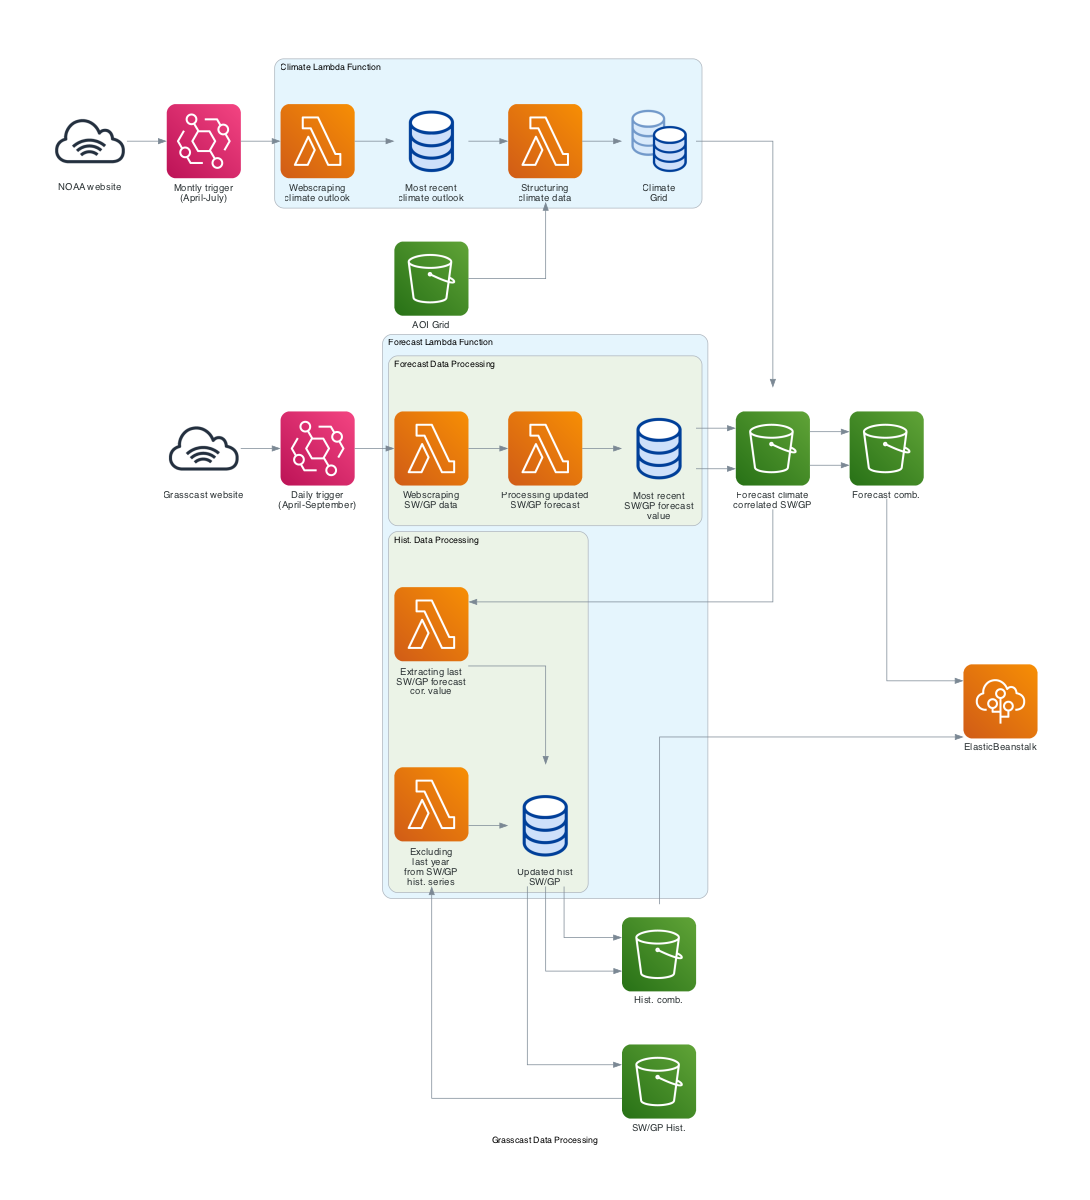

In [10]:
from diagrams import Diagram, Cluster, Edge
from diagrams.aws.compute import Lambda, EB
from diagrams.aws.storage import S3
from diagrams.aws.integration import Eventbridge
from diagrams.aws.general import InternetGateway
from diagrams.digitalocean.database import DbaasPrimary, DbaasStandby

graph_attrs = {
    #  "splines": "curved",
    "pad": "1",
    "nodesep": "0.50",
    "ranksep": "0.75",
    "fontname": "Sans-Serif",
    "fontsize": "12",
    "fontcolor": "#000000",
    "size": "6,6",
    "dpi": "200"
}

with Diagram("Grasscast Data Processing", show=False, direction="LR", graph_attr=graph_attrs) as diag:

    noaa_web = InternetGateway("NOAA website")
    aoi_grid = S3("AOI Grid")
    # Grasscast web SW and GP data
    grasscast_web_sw = InternetGateway("Grasscast website")

    # S3 and Database storage
    forecast_comb = S3("Forecast comb.")
    hist_comb = S3("Hist. comb.")

    app = EB("ElasticBeanstalk")

    eb1 = Eventbridge("Daily trigger\n(April-September)")
    eb2 = Eventbridge("Montly trigger\n(April-July)")
    
    # SW Data Processing Cluster
    sw_hist = S3("SW/GP Hist.")

    forecast_climate_correlated_sw = S3("Forecast climate\ncorrelated SW/GP")

    with Cluster("Forecast Lambda Function"):

        with Cluster("Hist. Data Processing"):
            all_hist_series_ex_last_year_sw = Lambda("Excluding\nlast year\nfrom SW/GP\nhist. series")
            last_forecast_cor_val_sw = Lambda("Extracting last\nSW/GP forecast\ncor. value")
            updated_hist_sw = DbaasPrimary("Updated hist\nSW/GP")
        with Cluster("Forecast Data Processing"):
            most_recent_sw_forecast_val = DbaasPrimary("Most recent\nSW/GP forecast\nvalue")
            webscraping_sw_data = Lambda("Webscraping\nSW/GP data")
            processing_updated_forecast_sw = Lambda("Processing updated\nSW/GP forecast")

    

    # NOAA Data Processing Cluster
    with Cluster("Climate Lambda Function"):
        webscraping_climate_outlook = Lambda("Webscraping\nclimate outlook")
        most_recent_climate_outlook = DbaasPrimary("Most recent\nclimate outlook")
        processing_clim_data = Lambda("Structuring\nclimate data")
        climate_grid = DbaasStandby("Climate\nGrid")

        # Connecting nodes within the NOAA Data Processing Cluster
        aoi_grid >> processing_clim_data 
        noaa_web >> eb2 >> webscraping_climate_outlook >> most_recent_climate_outlook >> processing_clim_data >> climate_grid

    # Connecting the other nodes
    # Grasscast web to webscraping
    grasscast_web_sw >> eb1 >> webscraping_sw_data >> processing_updated_forecast_sw >> most_recent_sw_forecast_val >> forecast_climate_correlated_sw >> forecast_comb >> app
    forecast_climate_correlated_sw >> forecast_comb
    most_recent_sw_forecast_val >> forecast_climate_correlated_sw
    updated_hist_sw >> sw_hist
    # Climate grid to forecast correlation
    climate_grid >> forecast_climate_correlated_sw

    # Processing historical data
    forecast_climate_correlated_sw >> last_forecast_cor_val_sw >> updated_hist_sw

    sw_hist >> all_hist_series_ex_last_year_sw >> updated_hist_sw >> hist_comb >> app
    updated_hist_sw >> hist_comb



diag

#### Climate Lambda Function

This function accesses NOAA's long-range precipitation outlook records, which are available at [https://ftp.cpc.ncep.noaa.gov/GIS/us_tempprcpfcst/](https://ftp.cpc.ncep.noaa.gov/GIS/us_tempprcpfcst/), and stores them in S3 storage services as a shapefile. It then reads the GrassCast grid and joins the outlooks' attributes by finding the largest overlap within each cell of the grid. The resulting file contains a dataset that includes each cell's ID, its association with a climate scenario, and the associated probability. This dataset will be further used in the Forecast Lambda Function.

Below is the code implemented for this purpose. Despite the final Lambda functions including the handlers and Lambda output structure, this code performs the same tasks as the ones running on AWS. Please note that it is already associated with the S3 bucket from which the app feeds. If you do not have access to S3, you can substitute the paths with your folders of interest and run it locally.

In [ ]:
#| eval: false

def lambda_function():

    # ------------------ Importing Libraries ------------------ #

    import boto3
    import pandas as pd
    import geopandas as gpd
    import json
    import sys
    import os
    import io
    import requests
    import zipfile
    import janitor
    from datetime import datetime
    from io import BytesIO
    from botocore.exceptions import NoCredentialsError

    # ------------------ AWS S3 parameters ------------------ #

    s3 = boto3.client('s3')  # Initializing Amazon S3 client
    bucket_name = 'foodsight-lambda'
    key_path_grasscast_grid_read = 'spatial_data/grasscast_aoi_grid.geojson'
    key_path_overlapping_gridids_read = 'spatial_data/overlapping_gridids.json'
    key_path_seasprcp_data_read = 'spatial_data/seasprcp_data'
    key_path_seasprcp_grid_read = 'spatial_data/seasprcp_grid.csv'


    # ------------------ Define functions ------------------#
    print("Defining helper functions...")

    ## Read/write functions:

    # Function to read a JSON file from S3
    def read_json_from_s3(bucket, key):
        response = s3.get_object(Bucket=bucket, Key=key)
        json_obj = response['Body'].read().decode('utf-8')
        return pd.DataFrame(json.loads(json_obj))

    # Function to read a GeoJSON file from S3 into a GeoPandas DataFrame
    def read_geojson_from_s3(bucket, key):
        geojson_obj = s3.get_object(Bucket=bucket, Key=key)
        return gpd.read_file(BytesIO(geojson_obj['Body'].read()))

    # Function to read a shapefile from S3 into a GeoPandas DataFrame
    def read_shapefile_from_s3(bucket_name, folder_path):
        # Create a temporary directory to store files
        local_dir = '/tmp/shp_folder/'
        if not os.path.exists(local_dir):
            os.makedirs(local_dir)

        # List all files in the S3 folder
        try:
            files = s3.list_objects_v2(Bucket=bucket_name, Prefix=folder_path)['Contents']
        except NoCredentialsError:
            return "Error: No AWS credentials found."
        except KeyError:
            return "Error: No files found in the specified bucket/folder."

        # Download each file in the folder to the local directory
        for file in files:
            file_name = file['Key'].split('/')[-1]
            if file_name.endswith('.shp') or file_name.endswith('.shx') or file_name.endswith('.dbf'):
                s3.download_file(bucket_name, file['Key'], local_dir + file_name)

        # Read the shapefile into a geopandas dataframe
        try:
            shp_files = [os.path.join(local_dir, f) for f in os.listdir(local_dir) if f.endswith('.shp')]
            if len(shp_files) == 0:
                return "Error: No .shp file found in the specified folder."
            gdf = gpd.read_file(shp_files[0])

            # Check if the CRS is set, if not, set it to a default (assuming WGS 84)
            if gdf.crs is None:
                gdf.set_crs(epsg=4326, inplace=True)
            else:
                # Transform CRS to WGS 84 (EPSG:4326) if needed
                gdf.to_crs(epsg=4326, inplace=True)
            return gdf

        except Exception as e:
            return "Error: " + str(e)

        finally:
            # Clean up the temporary directory
            for f in os.listdir(local_dir):
                os.remove(os.path.join(local_dir, f))
            os.rmdir(local_dir)
            
    # Function to save dataframe into S3
    def df_to_s3_csv(df, bucket, key):
        # Convert DataFrame to CSV in-memory
        csv_buffer = io.StringIO()
        df.to_csv(csv_buffer, index=False)
        # Convert String buffer to Bytes buffer
        csv_buffer_bytes = io.BytesIO(csv_buffer.getvalue().encode())
        # Upload to S3
        s3.put_object(Bucket=bucket, Body=csv_buffer_bytes.getvalue(), Key=key)


    ## Helper functions:

    # Function to access Climate Outlook files from NOAA Climate Prediction Center
    # More information at: https://www.cpc.ncep.noaa.gov/products/predictions/long_range/interactive/index.php
    def download_and_extract_seasprcp_files(year, month, s3_bucket, s3_folder):
        # Check if the month is between April and July
        if month < 3 or month > 7:
            return False

        base_url = 'https://ftp.cpc.ncep.noaa.gov/GIS/us_tempprcpfcst/'
        filename = 'seasprcp_{0:04d}{1:02d}.zip'.format(year, month)
        url = base_url + filename

        try:
            # Check and delete existing files in the S3 folder
            response = s3.list_objects_v2(Bucket=s3_bucket, Prefix=s3_folder)
            if 'Contents' in response:
                for obj in response['Contents']:
                    s3.delete_object(Bucket=s3_bucket, Key=obj['Key'])
            # Download the ZIP file
            response = requests.get(url)
            response.raise_for_status()
            # Create a temporary file for the ZIP
            temp_zip_path = '/tmp/' + filename
            with open(temp_zip_path, 'wb') as f:
                f.write(response.content)
            # Extract files and upload to S3
            with zipfile.ZipFile(temp_zip_path, 'r') as zip_ref:
                for file in zip_ref.namelist():
                    if file.startswith('lead1_'):
                        zip_ref.extract(file, '/tmp/')
                        # Splitting the file name and extension
                        file_name, file_extension = os.path.splitext(file)
                        # Renaming file with _prcp and year, preserving the original extension
                        new_filename = f"{file_name}_{month}_{year}{file_extension}"
                        os.rename('/tmp/' + file, '/tmp/' + new_filename)
                        s3.upload_file('/tmp/' + new_filename, s3_bucket, s3_folder + '/' + new_filename)
                        os.remove('/tmp/' + new_filename)
            # Remove the ZIP file after extraction
            os.remove(temp_zip_path)
            return "Files starting with 'lead1' extracted and uploaded to S3 successfully."

        except requests.exceptions.HTTPError as err:
            return "HTTP Error: " + str(err)
        except zipfile.BadZipFile:
            return "Error: The downloaded file is not a zip file."
        except Exception as e:
            return "Error: " + str(e)


    # Function to associate each grid cell to the climate outlook
    def join_attributes_by_largest_overlap(seasprcp_raw, precip_grid_raw):
        
        seasprcp_projected = seasprcp_raw.to_crs(epsg=4326)
        precip_grid_projected = precip_grid_raw.to_crs(epsg=4326)
        intersection = gpd.overlay(seasprcp_projected, precip_grid_projected, how='intersection')
        intersection['area'] = intersection.geometry.area
        intersection.sort_values(by='area', inplace=True)
        intersection.drop_duplicates(subset='gridid', keep='last', inplace=True)
        intersection = intersection.to_crs(epsg=4326)
        joined = seasprcp_raw.merge(intersection[['gridid','Cat','Prob']], left_on='gridid', right_on='gridid').clean_names()
        
        return joined

    # ------------------ Process and store updated Spatial Data ------------------#

    print("Downloading spatial data from NOAA CPC...")
    download_result = download_and_extract_seasprcp_files(datetime.now().year, datetime.now().month, bucket_name, key_path_seasprcp_data_read)
    if download_result is False:
        print("     No download required. Month is not between April and July.")
        sys.exit() 

    print("Preparing spatial data...")
    # Reference forecast to climate outlooks
    print("     Read climate data from S3...")
    seasprcp_raw = read_shapefile_from_s3(bucket_name, key_path_seasprcp_data_read)
    if isinstance(seasprcp_raw, str):
        print("         ",seasprcp_raw)
    else:
        print("         Climate data read successfully.")

    seasprcp_raw['Prob'] = seasprcp_raw['Prob'].apply(lambda x: (1/3)*100 if x == 33.0 else x)
    ## Read in AOI Grid
    print("     Read in AOI grid...")
    grasscast_aoi_grid = read_geojson_from_s3(bucket_name, key_path_grasscast_grid_read)
    # Apply function to associate each grid cell to the climate outlook
    print("     Join climate attributes to grid...")
    seasprcp_grid = join_attributes_by_largest_overlap(grasscast_aoi_grid, seasprcp_raw)
    # Save data
    print("Save spatial data outputs to S3...")
    df_to_s3_csv(seasprcp_grid, bucket_name, key_path_seasprcp_grid_read)

#### Forecast Lambda Function

As for the climate function, the lambda function responsible for updating GrassCast values shares much of the processing code implemented for generating the original datasets described in the Data section. This section provides the code required to web scrape data from GrassCast, retrieve the latest forecast values, correlate them with climate outlooks, and determine the expected forecast scenario. Additionally, the updated forecast dataset, ready for display, is used to update the historical series dataset by incorporating the most recent forecasted value and combining information from both regions (SW and GP) into a single dataset.

You can find the fully functional lambda function with its respective handler in the "aws-lambda" folder within the GitHub repository, ready to be executed.

In [9]:
#| eval: false

def lambda_function():

    # ------------------ Importing Libraries ------------------ #

    import sys
    from datetime import date, datetime, timedelta
    import pandas as pd
    import requests
    import janitor
    import json
    import io
    from io import BytesIO
    import boto3 

    # ------------------ AWS S3 parameters ------------------ #

    s3 = boto3.client('s3')  # Initializing Amazon S3 client
    bucket_name = 'foodsight-lambda'  # Name of the S3 bucket

    key_path_all_hist_read = 'hist_data/hist_data_grasscast_gp_sw.csv'
    key_path_gp_hist_read = 'hist_data/updated_hist_data_grasscast_gp.csv'
    key_path_sw_hist_read = 'hist_data/updated_hist_data_grasscast_sw.csv'

    key_path_all_forecast_read = 'forecast_data/forecast_data_grasscast_gp_sw.csv'
    key_path_gp_forecast_read = 'forecast_data/forecast_data_grasscast_gp_clim.csv'
    key_path_sw_forecast_read = 'forecast_data/forecast_data_grasscast_sw_clim.csv'

    key_path_seasprcp_grid_read = 'spatial_data/seasprcp_grid.csv'
    key_path_overlapping_gridids_read = 'spatial_data/overlapping_gridids.json'


    # S3 loading functions
    def read_csv_from_s3(bucket, key):
        csv_obj = s3.get_object(Bucket=bucket, Key=key)
        return pd.read_csv(BytesIO(csv_obj['Body'].read()))

    # Function to read a JSON file from S3
    def read_json_from_s3(bucket, key):
        response = s3.get_object(Bucket=bucket, Key=key)
        json_obj = response['Body'].read().decode('utf-8')
        return pd.DataFrame(json.loads(json_obj))

    # S3 saving function
    def df_to_s3_csv(df, bucket, key):
        # Convert DataFrame to CSV in-memory
        csv_buffer = io.StringIO()
        df.to_csv(csv_buffer, index=False)
        # Convert String buffer to Bytes buffer
        csv_buffer_bytes = io.BytesIO(csv_buffer.getvalue().encode())
        # Upload to S3
        s3.put_object(Bucket=bucket, Body=csv_buffer_bytes.getvalue(), Key=key)


    # ------------------ Define functions ------------------#
    # Predefined functions:

    # Function to pull the latest forecast data from the Grass-Cast website
    def download_forecast_lambda(year=date.today().year, region_code='gp', existing_df=None):
        base_url = "https://grasscast.unl.edu/data/csv/{year}/ANPP_forecast_summary_{region_code}_{year}_{month}_{day}.csv"
        month_names = {4: "April", 5: "May", 6: "June", 7: "July", 8: "August", 9: "September"}

        # List of shared columns
        shared_columns = ['fips', 'countystate', 'gridid', 'indx', 'year', 'meanndvigrid', 'meananppgrid', 
                        'ndvi_predict_below', 'npp_predict_below', 'npp_stdev_below', 'deltanpp_below', 
                        'pct_diffnpp_below', 'ndvi_predict_avg', 'npp_predict_avg', 'npp_stdev_avg', 
                        'deltanpp_avg', 'pct_diffnpp_avg', 'ndvi_predict_above', 'npp_predict_above', 
                        'npp_stdev_above', 'deltanpp_above', 'pct_diffnpp_above', 'report_date']

        start_date = datetime(year, 4, 1)  # Default start date is April 1st of the given year

        # If an existing dataframe is provided, find the next date after the latest report_date
        if existing_df is not None and not existing_df.empty:
            most_recent_report_date = pd.to_datetime(existing_df['report_date'].max()).year

            if most_recent_report_date != year :
                existing_df = None
            else:
                existing_df['report_date'] = pd.to_datetime(existing_df['report_date']).astype('datetime64[us]')
                last_date = existing_df['report_date'].max()
                start_date = last_date + timedelta(days=1)

        new_data_downloaded = False  # Flag to track if data is downloaded

        for month in range(start_date.month, 10):  # From starting month to September
            # Setting the end day of the month
            if month in [4, 6, 9]:  # April, June, September have 30 days
                end_day = 30
            else:
                end_day = 31

            for day in range(start_date.day if month == start_date.month else 1, end_day + 1):
                # Constructing the URL for each specific date
                url = base_url.format(year=year, region_code=region_code, month=month_names[month], day=day)
                try:
                    response = requests.get(url)
                    if response.status_code == 200:
                        print(f"Data found and downloaded for date: {year}-{month}-{day}")
                        print(url)
                        # Reading the CSV into a Pandas dataframe
                        new_df = pd.read_csv(url)
                        # Create report_date variable in date format
                        report_date = datetime(year, month, day)
                        new_df['report_date'] = report_date
                        # Rename the columns to lowercase and replace spaces with underscores
                        new_df = new_df.clean_names()
                        # Filter the dataframe to include only the shared columns
                        new_df = new_df[shared_columns]

                        # Concatenate with the existing dataframe
                        if existing_df is not None:
                            existing_df = pd.concat([existing_df, new_df], ignore_index=True)
                        else:
                            existing_df = new_df

                        new_data_downloaded = True
                        return existing_df

                    else:
                        print(f"No data available for date: {year}-{month}-{day}")
                except Exception as e:
                    print(f"Error downloading file for date: {year}-{month}-{day}, Error: {e}")

        if new_data_downloaded is False:
            print(f"No new data downloaded for {region_code} region. Stopping execution.")
            return None

   
    # Function to calculate ANPP based on climate outlook 
    def calculate_NPP_predict_clim(row):
        Cat = row['cat']
        Prob = row['prob']
        NPP_predict_below = row['npp_predict_below']
        NPP_predict_above = row['npp_predict_above']
        NPP_predict_avg = row['npp_predict_avg']

        if Cat == 'EC':
            return NPP_predict_below * (1/3) + NPP_predict_avg * (1/3) + NPP_predict_above * (1/3)
        else:
            # Calculate remaining_prob
            remaining_prob = 1 - ((Prob / 100) + (1/3))
            if Cat == 'Below':
                return (NPP_predict_below * (Prob / 100)) + NPP_predict_avg * (1/3) + NPP_predict_above * remaining_prob
            elif Cat == 'Above':
                return (NPP_predict_above * (Prob / 100)) + NPP_predict_avg * (1/3) + NPP_predict_below * remaining_prob


    # ------------------ Prepare Spatial Data ------------------#
    print("Reading spatial data...")
    # Read spatial data
    seasprcp_grid = read_csv_from_s3(bucket_name, key_path_seasprcp_grid_read)
    
    # ------------------ Pull new forecast data from GrassCast ------------------#

    # SW data
    print("Pulling SW data from GrassCast...")
    # Download the latest forecast data for the SW region
    # Load the previous forecast records (if any) to concatenate and set the start date 
    existing_df = read_csv_from_s3(bucket_name, key_path_sw_forecast_read)
    columns_to_exclude = ['cat', 'prob', 'npp_predict_clim']
    existing_df = existing_df[[col for col in existing_df.columns if col not in columns_to_exclude]]
    # Apply function
    grasscast_forecast_sw  = download_forecast_lambda(year=date.today().year, region_code='sw', existing_df=existing_df)

    # GP data
    print("Pulling GP data from GrassCast...")
    # Download the latest forecast data for the GP region
    # Load the previous forecast records (if any) to concatenate and set the start date
    existing_df = read_csv_from_s3(bucket_name, key_path_gp_forecast_read)
    columns_to_exclude = ['cat', 'prob', 'npp_predict_clim']
    existing_df = existing_df[[col for col in existing_df.columns if col not in columns_to_exclude]]
    # Apply function
    grasscast_forecast_gp = download_forecast_lambda(year=date.today().year, region_code='gp', existing_df=existing_df)

    # Stop execution if no new data was downloaded
    if grasscast_forecast_sw is None and grasscast_forecast_gp is None:
        print("No new data available. Stopping execution.")
        sys.exit()

    # ------------------ Apply updates for SW ------------------#

    if grasscast_forecast_sw is not None:
        print("Updating SW data...")

        # Add new climate related variables to the forecast dataset
        # Merge forecast data with grid based on Id
        grasscast_forecast_sw_clim = pd.merge(grasscast_forecast_sw, 
                                            seasprcp_grid[['gridid', 'cat', 'prob']], 
                                            left_on='gridid', right_on='gridid', how='left')
        # Apply function to calculate ANPP based on climate outlook to SW DataFrame
        grasscast_forecast_sw_clim['npp_predict_clim'] = grasscast_forecast_sw_clim.apply(calculate_NPP_predict_clim, axis=1)
        # Store the updated forecast dataset to be used in the following iteration to pull updated data from GrassCast
        df_to_s3_csv(grasscast_forecast_sw_clim, bucket_name, key_path_sw_forecast_read)

        # Update last record on the historical dataset based on new forecast data
        # Load last available historical data
        hist_sw = read_csv_from_s3(bucket_name, key_path_sw_hist_read)
        forecast_sw = grasscast_forecast_sw_clim
        # Assuming grasscast_forecast_sw_clim is already loaded as forecast_sw
        forecast_sw['report_date'] = pd.to_datetime(forecast_sw['report_date'])
        # Filter for the last day of May and the last day of the year
        last_day_may = forecast_sw[forecast_sw['report_date'].dt.month == 5].groupby('year')['report_date'].max()
        last_day_year = forecast_sw.groupby('year')['report_date'].max()
        # Group by 'year' and get the last 'report_date'
        max_dates_per_year = pd.concat([last_day_may, last_day_year])
        # Merge the DataFrames
        result = pd.merge(forecast_sw, max_dates_per_year, on=['year', 'report_date'])
        # Extract the month and assign seasons
        result['month'] = result['report_date'].dt.month
        result['season'] = result['month'].apply(lambda x: 'spring' if 4 <= x < 6 else 'summer')
        # Assign values to the new columns based on the season
        result['predicted_spring_anpp_lbs_ac'] = result.apply(lambda row: row['npp_predict_clim'] if row['season'] == 'spring' else None, axis=1)
        result['predicted_summer_anpp_lbs_ac'] = result.apply(lambda row: row['npp_predict_clim'] if row['season'] == 'summer' else None, axis=1)
        # Filter out years from hist_sw that are also present in forecast_sw
        forecast_years = forecast_sw['report_date'].dt.year.unique()
        hist_sw = hist_sw[~hist_sw['year'].isin(forecast_years)]
        # Select the specified columns
        selected_columns_hist = hist_sw[["gridid", "year", "predicted_spring_anpp_lbs_ac", "predicted_summer_anpp_lbs_ac"]]
        selected_columns_forecast = result[["gridid", "year", "predicted_spring_anpp_lbs_ac", "predicted_summer_anpp_lbs_ac"]]
        # Group and merge
        merged_selected_columns_forecast = selected_columns_forecast.groupby(['gridid', 'year'], as_index=False).first()
        hist_sw = pd.concat([selected_columns_hist, merged_selected_columns_forecast], ignore_index=True)
        # Store updated historical dataset for the next iteration
        df_to_s3_csv(hist_sw, bucket_name, key_path_sw_hist_read)


    # ------------------ Apply updates for GP ------------------#

    if grasscast_forecast_gp is not None:
        print("Updating GP data...")

        # Add new climate related variables to the forecast dataset
        # Merge forecast data with grid based on Id
        grasscast_forecast_gp_clim = pd.merge(grasscast_forecast_gp, 
                                            seasprcp_grid[['gridid', 'cat', 'prob']], 
                                            left_on='gridid', right_on='gridid', how='left')
        # Apply function to calculate ANPP based on climate outlook to SW DataFrame
        grasscast_forecast_gp_clim['npp_predict_clim'] = grasscast_forecast_gp_clim.apply(calculate_NPP_predict_clim, axis=1)
        
        # GP and SW grids overlap, so we need to remove the overlapping grids from the GP dataset which is the less informative (only one seasonal forecast)
        # Read in overlapping grid ids
        overlapping_ids = read_json_from_s3(bucket_name, key_path_overlapping_gridids_read)
        # Convert the 'gridid' in overlapping_ids to a set for faster lookup
        overlapping_ids_set = set(overlapping_ids['gridid'])
        # Create a boolean index for rows in combined_df where 'gridid' is not in overlapping_ids_set
        non_overlapping_index = ~grasscast_forecast_gp_clim['gridid'].isin(overlapping_ids_set)
        # Filter the combined_df using this index
        grasscast_forecast_gp_clim = grasscast_forecast_gp_clim[non_overlapping_index]
        # Store the updated forecast dataset to be used in the following iteration to pull updated data from GrassCast
        df_to_s3_csv(grasscast_forecast_gp_clim, bucket_name, key_path_gp_forecast_read)


        # Update last record on the historical dataset based on new forecast data
        # Load last available historical data
        hist_gp = read_csv_from_s3(bucket_name, key_path_gp_hist_read)
        forecast_gp = grasscast_forecast_gp_clim
        # Convert the 'Date' column to datetime if it's not
        forecast_gp['report_date'] = pd.to_datetime(forecast_gp['report_date'])
        # Filter the dataframe for the last day of the year
        max_dates_per_year = forecast_gp.groupby('year')['report_date'].max()
        # Merge the DataFrames
        result = pd.merge(forecast_gp, max_dates_per_year, on=['year', 'report_date'])
        # Assign the value from npp_predict_clim to anpp_lbs_ac or predicted_summer_anpp_lbs_ac
        result['anpp_lbs_ac'] = result.apply(lambda row: row['npp_predict_clim'], axis=1)
        # Filter out years from hist_sw that are also present in forecast_sw
        forecast_years = forecast_gp['report_date'].dt.year.unique()
        hist_gp = hist_gp[~hist_gp['year'].isin(forecast_years)]
        # Select the specified columns from hist_grasscast_gp
        selected_columns_hist = hist_gp[["gridid", "year", "anpp_lbs_ac"]]
        selected_columns_forecast = result[["gridid", "year", "anpp_lbs_ac"]]
        merged_selected_columns_forecast = selected_columns_forecast.groupby(['gridid', 'year'], as_index=False).first()
        hist_gp = pd.concat([selected_columns_hist, merged_selected_columns_forecast], ignore_index=True)
        # Store updated historical dataset for the next iteration
        df_to_s3_csv(hist_gp, bucket_name, key_path_gp_hist_read)


    # ------------------ Combine SW and GP dataframes ------------------#
    print("Combining SW and GP dataframes and preparing files...")

    # Read in files
    # Reloading the datasets to prevent potential problems associated when pulling GrassCast data from one of the regions
    hist_gp = read_csv_from_s3(bucket_name, key_path_gp_hist_read)
    hist_sw = read_csv_from_s3(bucket_name, key_path_sw_hist_read)
    forecast_gp = read_csv_from_s3(bucket_name, key_path_gp_forecast_read)
    forecast_sw = read_csv_from_s3(bucket_name, key_path_sw_forecast_read)

    # Concatenate GP and SW and create the final datasets to be used in the APP
    df_hist = pd.concat([hist_sw, hist_gp], ignore_index=True)
    df_forecast = pd.concat([forecast_sw, forecast_gp], ignore_index=True)
    # Store the resulting datasets to be read in the APP
    df_to_s3_csv(df_hist, bucket_name, key_path_all_hist_read)
    df_to_s3_csv(df_forecast, bucket_name, key_path_all_forecast_read)
    print("Execution completed successfully.")

### Market Data Updates

As mentioned previously, most of the data displayed on the Markets page of the application is directly retrieved from the MMN API within the app. However, for the top market table and the weight vs. prices plot, the structure of the data pulled from the API cannot be used to generate the visualizations. Therefore, an additional Lambda function has been implemented to retrieve daily market auction cattle data, filter it, and restructure it to be compatible with the app.

Specifically, the code below, included in the respective Lambda function, retrieves all available auction livestock data for the markets listed in the JSON "markets_data_final," which originates from the markets filtering process described in the "Listing available markets for Cattle and Hay" section. For those markets with data available from the last 30 days, the data is stored in S3 and made ready for use within the app.

In [ ]:
#| eval: false

def lambda_funtion():

    import requests  # For making HTTP requests
    import json  # For handling JSON data
    import boto3  # AWS SDK for Python, allows Python scripts to use services like Amazon S3 and Amazon EC2
    from concurrent.futures import ThreadPoolExecutor  # For parallel execution

    # Constants
    base_url = "https://marsapi.ams.usda.gov"  # Base URL for the marsapi
    api_key = open("foodsight-app/.mmn_api_token").read()   # API key for authentication with marsapi
    s3 = boto3.client('s3')  # Initializing Amazon S3 client
    bucket_name = 'foodsight-lambda'  # Name of the S3 bucket
    key_path_read = 'market_data/markets_data_final.json'  # Path to the JSON file in the S3 bucket

    # Function to fetch data from marsapi
    def get_data_from_marsapi(endpoint):
        with requests.Session() as session:  # Creates a session to manage connections
            response = session.get(base_url + endpoint, auth=(api_key, ''))  # Sends GET request
            
            # Checks if the response status is 200 (OK)
            if response.status_code == 200:
                return response.json()  # Returns JSON content of the response
            else:
                response.raise_for_status()  # Raises an exception if the response contains an error

    # Function to fetch market data
    def fetch_data_for_market(market):
        slug_id = market['slug_id']
        market_name = market['market_location_name']
        print(f"Fetching data for {market_name} (Slug ID: {slug_id})...")

        # Endpoint to check data availability for the last 30 days
        endpoint_limit = f"/services/v1.2/reports/{slug_id}/Details?lastDays=30&market_type=Auction Livestock"
        data_limit = get_data_from_marsapi(endpoint_limit)

        # Checks if there's data for the last 30 days
        if data_limit and 'results' in data_limit and data_limit['results']:
            lastDay = 1  # Initializes day counter
            while lastDay <= 30:  # Loop to search data day-by-day for the last 30 days
                endpoint = f"/services/v1.2/reports/{slug_id}/Details?lastDays={lastDay}&market_type=Auction Livestock"
                data = get_data_from_marsapi(endpoint)

                # Checks if data is available for the day
                if data and 'results' in data and data['results']:
                    print(f"Data found for {slug_id} at lastDay={lastDay}")
                    return data['results']

                # If no data found for the day, print a message and check the next day
                print(f"No data found for {slug_id} at lastDay={lastDay}. Trying next day...")
                lastDay += 1

        # If no data found for the last 30 days, print a message and move to the next market
        print(f"No data found for {slug_id} within the last 30 days. Moving to the next slug_id.")
        return []

    # Function to fetch data for all markets
    def fetch_all_data(markets_list):
        all_data = []

        # Parallel execution using ThreadPoolExecutor
        with ThreadPoolExecutor() as executor:
            results = list(executor.map(fetch_data_for_market, markets_list))

        # Aggregates all data
        for data in results:
            if data:
                all_data.extend(data)

        return all_data

    # Fetching market list from S3
    response = s3.get_object(Bucket=bucket_name, Key=key_path_read)  # Fetches the object from the S3 bucket
    markets_list = json.loads(response['Body'].read().decode('utf-8'))  # Decodes and loads the JSON data

    # Fetches data for all markets
    last_market_data = fetch_all_data(markets_list)

    # Converts the aggregated data to JSON and uploads to S3
    json_content = json.dumps(last_market_data)
    json_bytes = json_content.encode('utf-8')
    
    key_path_write = 'market_data/last_market_data.json'
    s3.put_object(Bucket=bucket_name, Key=key_path_write, Body=json_bytes)
    print(f"Store data at: bucket {bucket_name}, key {key_path_write}")

        


In contrast to the Forecast Lambdas, the simplicity in terms of required dependencies for this function has enabled it to be deployed directly from a zip file containing all the preinstalled dependencies. You can install it using the command provided in the "readme.txt" file.

## Resources

FoodSight combines a range of resources from various sources, including government agencies and universities, into a user-friendly platform. This integration facilitates access to data, enhancing its representation, and providing basic analysis tools. Among these resources, the core components of the app include:


### Productivity Forecast

The Grassland Productivity Forecast is a GrassCast product developed by the University of Nebraska-Lincoln, specifically designed for land managers and ranchers. This tool utilizes nearly 40 years of historical weather and vegetation data, combined with seasonal precipitation forecasts, to predict grassland productivity. It assesses whether productivity, measured in pounds per acre, is likely to be above-normal, near-normal, or below-normal for the upcoming season. GrassCast is updated bi-weekly during spring and summer, adjusting to the expected weather for that season, thus providing crucial insights for grazing management.

You can learn more about the project and access the forecast data in the form of static maps and CSV files at [GrassCast](https://grasscast.unl.edu).

To know what forecast scenario is more likely to occur, you can visit the [long-range precipitation outlooks provided by NOAA](https://www.cpc.ncep.noaa.gov/products/predictions/long_range/interactive/index.php).



### Market Data

[USDA Market News](https://www.ams.usda.gov/market-news) provides essential resources for those interested in livestock market information. You can access detailed historical data and reports on sales, nominal prices, volumes, and market trends for various agricultural categories and commodities. This [data is available for download](https://www.marketnews.usda.gov/mnp/ls-report-config?category=Calves) in .xls, .txt, .xml, and .pdf formats, covering records from 2000 to 2019 depending on the commodity. For the most recent data—2019 and onwards—, USDA provides free access to the [My Market News API](https://mymarketnews.ams.usda.gov). This API is a powerful tool for developers and analysts, offering customized market data feeds and integration capabilities for several systems or applications. These resources—feeding FoodSight’s markets page— are invaluable for stakeholders in the livestock industry, providing real-time and detailed market data to support buying, selling, and production decisions.



### Decision Support Tool

Several farming and ranching decision support tools have been released and are publicly available online. For the FoodSight beta version, we explored the potential interest of users in combining insights from the forecast and market pages for informed ranching management decisions, especially during drought events. Therefore, we incorporated guidelines and suggestions derived from 'Strategies for Beef Cattle Herds During Times of Drought', a tool designed by Jeffrey E. Tranel, Rod Sharp, & John Deering from the Department of Agriculture and Business Management at Colorado State University. The goal of this decision tool is to assist cow producers in comparing the financial implications of different management strategies during droughts when grazing forage is scarce.

See [Strategies for Beef Cattle Herds During Times of Drought](https://www.extension.colostate.edu) for more information. Tool available in Excel format.
